 <div style="border:solid steelblue 3px; padding: 20px">
<font size="5"> <b> Задача - Разработать модель для предсказания успешности стартапа (закроется или нет)</b></font>
<br />Описание задачи
<br />Соревнование представляет собой увлекательный и практически важный опыт, ориентированный на студентов курса Data Science. Участникам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Соревнование проводится на популярной платформе Kaggle, что позволяет участникам не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой.

Срок проведения соревнования составляет 2 недели.

<br />Данные
<br />Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'
<br />kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
<br />kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
<br />kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
<br />name - идентификатор (название) стартапа в тестовом наборе.
<br />status - целевой признак. Для каждого стартапа предскажите категориальное значение соответствующее прогнозу ['operating', 'closed'].
<br />Описание полей данных
<br />name - Название стартапа
<br />category_list - Список категорий, к которым относится стартап
<br />funding_total_usd - Общая сумма финансирования в USD
<br />status - Статус стартапа (закрыт или действующий)
<br />country_code - Код страны
<br />state_code - Код штата
<br />region - Регион
<br />city - Город
<br />funding_rounds - Количество раундов финансирования
<br />founded_at - Дата основания
<br />first_funding_at - Дата первого раунда финансирования
<br />last_funding_at - Дата последнего раунда финансирования
<br />closed_at - Дата закрытия стартапа (если применимо)
<br />lifetime - Время существования стартапа в днях

<br />Evaluation
<br />Оценка качества предсказаний - 
Метрикой в этом соревновании является F1-Score.

In [1]:
#!pip install -U catboost
#!pip install -U Matplotlib 
#!pip install -U numpy 
#!pip install -U shap
#!pip install -U scikit-learn 
#!pip install scikit-learn==1.2.2 
#!pip install -U phik
#!pip install -U shap
#!pip install --upgrade numba
#!pip install --upgrade imblearn
#!pip install --upgrade lime

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.metrics import  f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn.pipeline import Pipeline
import warnings
import catboost 
from catboost import CatBoostClassifier
from catboost import cv
from catboost import Pool
import phik
import shap
import optuna
from optuna.integration import OptunaSearchCV
from optuna import distributions
from imblearn.over_sampling import SMOTENC
from sklearn.dummy import DummyClassifier
import lime
import lime.lime_tabular
from sklearn.impute import KNNImputer
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
#pip list

## Загрузка данных

In [4]:
df_train = pd.read_csv('kaggle_startups_train_28062024.csv',index_col=0)
df_test = pd.read_csv('kaggle_startups_test_28062024.csv',index_col=0)
df_sample = pd.read_csv('kaggle_startups_sample_submit_28062024.csv',index_col=0)

In [5]:
df_train.head()

category_list  \
name                                                            
Lunchgate                     Online Reservations|Restaurants   
EarLens                 Manufacturing|Medical|Medical Devices   
Reviva Pharmaceuticals                          Biotechnology   
Sancilio and Company                              Health Care   
WireTough Cylinders                             Manufacturing   

                        funding_total_usd     status country_code state_code  \
name                                                                           
Lunchgate                        828626.0  operating          CHE         25   
EarLens                        42935019.0  operating          USA         CA   
Reviva Pharmaceuticals         35456381.0  operating          USA         CA   
Sancilio and Company           22250000.0  operating          NaN        NaN   
WireTough Cylinders                   NaN  operating          USA         VA   

                             region          city  funding_rounds  founded_at  \
name                                                                            
Lunchgate                    Zurich        Zürich               2  2009-10-17   
EarLens                 SF Bay Area  Redwood City               4  2005-01-01   
Reviva Pharmaceuticals  SF Bay Area      San Jose               3  2006-01-01   
Sancilio and Company            NaN           NaN               3  2004-01-01   
WireTough Cylinders      VA - Other       Bristol               1  2010-05-12   

                       first_funding_at last_funding_at closed_at  
name                                                               
Lunchgate                    2011-05-01      2014-12-01       NaN  
EarLens                      2010-05-04      2014-02-25       NaN  
Reviva Pharmaceuticals       2012-08-20      2014-07-02       NaN  
Sancilio and Company         2011-09-01      2014-07-18       NaN  
WireTough Cylinders          2012-02-01      2012-02-01       NaN

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category_list      50051 non-null  object 
 1   funding_total_usd  42447 non-null  float64
 2   status             52516 non-null  object 
 3   country_code       47014 non-null  object 
 4   state_code         45753 non-null  object 
 5   region             46157 non-null  object 
 6   city               46157 non-null  object 
 7   funding_rounds     52516 non-null  int64  
 8   founded_at         52516 non-null  object 
 9   first_funding_at   52516 non-null  object 
 10  last_funding_at    52516 non-null  object 
 11  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 5.2+ MB


In [7]:
df_test.head()

category_list  funding_total_usd  \
name                                                                        
Crystalsol                            Clean Technology          2819200.0   
JBI Fish & Wings                           Hospitality                NaN   
COINPLUS                                       Finance           428257.0   
Imagine Communications  Software|Video|Video Streaming         34700000.0   
DNA13                                         Software          4530000.0   

                       country_code state_code            region  \
name                                                               
Crystalsol                      NIC         17               NaN   
JBI Fish & Wings                USA         TN        TN - Other   
COINPLUS                        LUX          3  Esch-sur-alzette   
Imagine Communications          USA         CA         San Diego   
DNA13                           CAN         ON            Ottawa   

                                    city  funding_rounds first_funding_at  \
name                                                                        
Crystalsol                           NaN               1       2009-07-01   
JBI Fish & Wings                Humboldt               1       2010-07-28   
COINPLUS                Esch-sur-alzette               2       2014-05-15   
Imagine Communications         San Diego               4       2005-01-01   
DNA13                             Ottawa               1       2007-05-08   

                       last_funding_at  lifetime  
name                                              
Crystalsol                  2009-07-01      3501  
JBI Fish & Wings            2010-07-28      2717  
COINPLUS                    2014-09-18      1295  
Imagine Communications      2010-04-20      4748  
DNA13                       2007-05-08      6209

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category_list      12534 non-null  object 
 1   funding_total_usd  10547 non-null  float64
 2   country_code       11743 non-null  object 
 3   state_code         11430 non-null  object 
 4   region             11536 non-null  object 
 5   city               11538 non-null  object 
 6   funding_rounds     13125 non-null  int64  
 7   first_funding_at   13125 non-null  object 
 8   last_funding_at    13125 non-null  object 
 9   lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 1.1+ MB


In [9]:
df_sample.value_counts()

status   
operating    6635
closed       6490
Name: count, dtype: int64

In [10]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   status  13125 non-null  object
dtypes: object(1)
memory usage: 205.1+ KB


## Предобработка данных

Посмотрим есть ли аномальные значения в столбцах с типами int и float

In [11]:
df_train.describe()

funding_total_usd  funding_rounds
count       4.244700e+04    52516.000000
mean        1.824748e+07        1.740670
std         1.871173e+08        1.374522
min         1.000000e+00        1.000000
25%         3.360275e+05        1.000000
50%         2.000000e+06        1.000000
75%         1.000000e+07        2.000000
max         3.007950e+10       19.000000

In [12]:
df_test.describe()

funding_total_usd  funding_rounds      lifetime
count       1.054700e+04    13125.000000  13125.000000
mean        1.654910e+07        1.714438   3097.609524
std         9.217283e+07        1.318800   2128.356554
min         1.000000e+00        1.000000     52.000000
25%         3.200000e+05        1.000000   1726.000000
50%         2.000000e+06        1.000000   2526.000000
75%         1.000000e+07        2.000000   3866.000000
max         4.715000e+09       15.000000  17167.000000

Аномальных значений в столбцах не найдено. Проверим данные на неявные дубликаты и ошибки

In [13]:
df_sample.head()

status
name                             
Crystalsol                 closed
JBI Fish & Wings        operating
COINPLUS                   closed
Imagine Communications     closed
DNA13                   operating

In [14]:
df_train['status'].value_counts()

status
operating    47599
closed        4917
Name: count, dtype: int64

In [15]:
df_train['category_list'].value_counts().head()

category_list
Software            3207
Biotechnology       2905
E-Commerce          1064
Mobile               920
Clean Technology     892
Name: count, dtype: int64

In [16]:
len(df_train['category_list'].value_counts())

22105

Видим огромное количество признаков. Сделаем первичную предобработку.
Так как много признаков состоят из одинаковых простых признаков, разделенных "|", разделим и перенесем их по отдельным столбцам.
Далее в первом основном столбце категорий cat_0 заменим отсутстующие значения на Not_used,
в остальных столбцах заменим отсутстующие значения на Others, в связи с возможными разными группами совсем незаполненных признаков и заполненных одним или несколькими категориями.

In [17]:

df_train[['cat_0','cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11' ]]= df_train['category_list'].str.split('|', n = 11, expand = True)
df_test[['cat_0','cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11']]= df_test['category_list'].str.split('|', n = 11, expand = True)
df_train['cat_11'] = df_train['cat_11'].str.split('|', expand = True)[0]
df_test['cat_11'] = df_test['cat_11'].str.split('|', expand = True)[0]
df_train['cat_0'] = df_train['cat_0'].fillna('Not_used')
df_test['cat_0'] = df_test['cat_0'].fillna('Not_used')
df_train[['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11' ]] = df_train[['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11']].fillna('Others')
df_test[['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11']] = df_test[['cat_1', 'cat_2', 'cat_3', 'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10', 'cat_11']].fillna('Others')
df_test = df_test.drop('category_list', axis =1)
df_train = df_train.drop('category_list', axis =1)


Постараемся укрупнить признаки

In [18]:
def categ_unify(df, in_cat, out_cat):
    for item_in, item_out in zip(in_cat, out_cat):
        df =df.replace(item_in, item_out)
    return df
df_cat = pd.DataFrame([['iPhone','Mobile'],
                       ['Android','Mobile'],
                       ['Mobile Security','Mobile'],
                       ['Mobility','Mobile'],
                       ['iOS','Software'],
                       ['Apps', 'Software'],
                       ['Developer APIs','Software'],
                       ['Facebook Applications','Software'],
                       ['Twitter Applications','Software'],
                       ['SaaS','Software'],
                       ['Application Platforms','Software'],
                       ['Web Tools', 'Software'],
                       ['Social Media', 'Media'],
                       ['Social Network Media','Media'],
                       ['Digital Media','Media'],
                       ['Music', 'Media'],
                       ['Video', 'Media'],
                       ['News', 'Media'],
                       ['Content','Media'],
                       ['Audio', 'Media'],
                       ['Video Streaming', 'Media'],
                       ['Broadcasting', 'Media'],
                       ['Content Delivery','Media'],
                       ['Content Creators','Media'],
                       ['Big Data Analytics', 'Big Data'],
                       ['Fitness', 'Health and Wellness'],
                       ['Health Care', 'Health and Wellness'],
                       ['Health and Wellness Information Technology', 'Health and Wellness'],
                       ['Health Care Information Technology', 'Health and Wellness'],
                       ['Health Diagnostics','Health and Wellness'],
                       ['Healthcare Services','Health and Wellness'],
                       ['E-Commerce','Sales and Marketing'],
                       ['Marketplaces','Sales and Marketing'],
                       ['Retail','Sales and Marketing'],
                       ['Media Marketing','Sales and Marketing'],
                       ['Social Commerce','Sales and Marketing'],
                       ['Internet Marketing','Sales and Marketing'],
                       ['Social Media Marketing','Sales and Marketing'],
                       ['Shopping', 'Sales and Marketing'],
                       ['App Marketing','Sales and Marketing'],
                       ['Mobile Shopping', 'Sales and Marketing'],
                       ['Mobile Commerce', 'Sales and Marketing'],
                       ['Online Shopping', 'Sales and Marketing'],
                       ['Brand Marketing', 'Sales and Marketing'],
                       ['Networking', 'Information Technology'],
                       ['Messaging','Information Technology'],
                       ['Location Based Services', 'Telecommunications'],
                       ['Wireless','Telecommunications'],
                       ['Service Providers', 'Telecommunications' ],
                       ['Consumer Internet','Telecommunications'],
                       ['Internet of Things','Information Technology'],
                       ['Consumer Electronics','Electronics'],
                       ['Consumer Goods','Consumers'],
                       ['Communications Infrastructure', 'Information Technology'],
                       ['Chat','Information Technology'],
                       ['Internet','Information Technology'],
                       ['Email', 'Information Technology'],
                       ['VoIP','Telecommunications'],
                       ['Gps','Information Technology'],
                       ['Biometrics','Health and Wellness'],
                       ['Bioinformatics', 'Biotechnology'],
                       ['FinTech','Finance Technology'],
                       ['Financial Services', 'Finance'],
                       ['PaaS', 'Cloud Computing'],
                       ['Development Platforms', 'Hardware + Software'],
                       ['3D Printing', '3D'],
                       ['3D Technology', '3D'],
                       ['Video Games','Game'],
                       ['Mobile Games','Game'],
                       ['Data Center Automation','Cloud Computing'],
                       ['Mobile Advertising', 'Advertising'],
                       ['Employment','Human Resources'],
                       ['Recruiting','Human Resources'],
                       ['Career Management', 'Human Resources'],
                      ['Speech Recognition', 'Artificial Intelligence'],
                       ['All Students', 'Education'],
                       ['Alumni','Education'],
                       ['EdTech','Education'],
                       ['Colleges','Education'],
                       ['Public Transportation','Transportation'],
                       ['Cyber Security','Security'],
                       ['Data Security','Security'],
                       ['Cloud Security','Security'],
                       ['Network Security','Security'],
                       ['Home Automation', 'Automation'],
                       ['Billing', 'Finance Technology'],
                       ['Cars', 'Auto'],
                       ['Automotive','Auto'],
                       ['Customer Service', 'Services'],
                       ['Cloud Infrastructure','Cloud Computing'],
                       ['Data Centers','Cloud Computing'],
                       ['Commercial Real Estate','Real Estate'],
                       ['Hotels','Real Estate'],
                       ['Online Travel','Travel'],
                       ['Ad Targeting', 'Advertising'],
                       ['Advertising Platforms','Advertising'],
                       ['Information Services', 'Search'],
                       ['Cloud Data Services','Cloud Computing'],
                       ['Business Productivity','Business Development'],
                       ['Bridging Online and Offline','Information Technology'],
                       ['Bio-Pharm','Biotechnology'],
                       ['Adventure Travel','Travel'],
                       ['Energy Efficiency','Energy'],
                       ['Clean Energy','Clean Technology'],
                       ['File Sharing','Information Technology'],
                       ['Databases','Information Technology'],
                       ['Medical Devices','Health and Wellness'],
                       ['Data Integration','Information Technology'],
                       ['Leisure','Entertainment'],
                       ['Marketing Automation','Sales and Marketing'],
                       ['Industrial','Manufacturing'],
                       ['Chemicals','Manufacturing'],
                       ['Data Visualization','Software'],
                       ['Web Hosting','Information Technology'],
                       ['Web Development','Information Technology'],
                       ['Entrepreneur','Business Development'],
                       ['Business Intelligence','Business Development'],
                       ['Local Businesses','Business Development'],
                       ['Business Services','Business Development'],
                       ['Publishing','Media'],
                       ['Environmental Innovation','Clean Technology'],
                       ['E-Commerce Platforms','Sales and Marketing'],
                       ['Clinical Trials','Health and Wellness'],
                       ['Business Analytics','Analytics'],
                       ['Machine Learning','Artificial Intelligence'],
                       ['Algorithms','Artificial Intelligence'],
                       ['Dental','Health and Wellness'],
                       ['Medical','Health and Wellness'],
                       ['Communications Hardware','Hardware'],
                       ['Architecture','Construction'],
                       ['Content Discovery','Media'],
                       ['Cloud Management','Cloud Computing'],
                       ['Computers','Hardware + Software'],
                       ['Browser Extensions','Software'],
                       ['Developer Tools','Software'],
                       ['Doctors','Health and Wellness'],
                       ['Credit','Finance'],
                       ['Discounts','Sales and Marketing'],
                       ['Mobile Payments','Finance Technology'],
                       ['Accounting','Finance Technology'],
                       ['Career Planning','Human Resources'],
                       ['Application Performance Monitoring','Cloud Computing'],
                       ['Market Research','Sales and Marketing'],
                       ['Information Security','Security'],
                       ['Online Rental','Real Estate'],
                       ['Travel & Tourism','Travel'],
                       ['Fantasy Sports','Sports'],
                       ['College Recruiting','Education'],
                       ['Comparison Shopping','Sales and Marketing'],
                       ['Energy Management','Energy'],
                       ['Tourism','Travel'],
                       ['Logistics Company','Logistics'],
                       ['Meeting Software','Software'],
                       ['Designers ','Design'],
                       ['Email Marketing','Sales and Marketing'],
                       ['Intelligent Systems','Artificial Intelligence'],
                       ['Small and Medium Businesses','Business Development'],
                       ['Advertising Networks','Advertising'],
                       ['Electronic Health Records','Health and Wellness'],
                       ['Corporate Training','Education'],
                       ['Payments','Finance Technology'],
                       ['iPad','Mobile'],
                       ['Mobile Devices','Mobile'],
                       ['Educational Games','Education'],
                       ['Enterprise 2.0','Information Technology'],
                       ['Ediscovery','Information Technology'],
                       ['Digital Signage','Advertising'],
                       ['Employer Benefits Programs','Human Resources'],
                       ['Automated Kiosk','Sales and Marketing'],
                       ['Computer Vision','Artificial Intelligence'],
                       ['Credit Cards','Finance Technology'],
                       ['Investment Management','Business Development'],
                       ['Babies','Kids'],
                       ['Electrical Distribution','Energy']
                       
                      ],
columns=['old_category', 'new_category'])

df_train = categ_unify(df_train, df_cat['old_category'], df_cat['new_category'])
df_test = categ_unify(df_test, df_cat['old_category'], df_cat['new_category'])

Далее обрежем категории с небольшим количеством стартапов

In [19]:
df_train['cat_0'].value_counts().shape[0]

540

In [20]:

df_train_top_cat_0 = df_train['cat_0'].value_counts().head(100)
df_train_top_cat_1= df_train['cat_1'].value_counts().head(100)
df_train_top_cat_2= df_train['cat_2'].value_counts().head(100)
df_train_top_cat_3= df_train['cat_3'].value_counts().head(95)
df_train_top_cat_4= df_train['cat_4'].value_counts().head(95)
df_train_top_cat_0 = df_train_top_cat_0.to_frame().reset_index()
df_train_top_cat_1 = df_train_top_cat_1.to_frame().reset_index()
df_train_top_cat_2 = df_train_top_cat_2.to_frame().reset_index()
df_train_top_cat_3 = df_train_top_cat_3.to_frame().reset_index()
df_train_top_cat_4 = df_train_top_cat_4.to_frame().reset_index()
df_train['cat_0'] = df_train.query('cat_0 in @df_train_top_cat_0["cat_0"]')['cat_0']
df_test['cat_0'] = df_test.query('cat_0 in @df_train_top_cat_0["cat_0"]')['cat_0']
df_train['cat_1'] = df_train.query('cat_1 in @df_train_top_cat_1["cat_1"]')['cat_1']
df_test['cat_1'] = df_test.query('cat_1 in @df_train_top_cat_1["cat_1"]')['cat_1']
df_train['cat_2'] = df_train.query('cat_2 in @df_train_top_cat_2["cat_2"]')['cat_2']
df_test['cat_2'] = df_test.query('cat_2 in @df_train_top_cat_2["cat_2"]')['cat_2']
df_train['cat_3'] = df_train.query('cat_3 in @df_train_top_cat_3["cat_3"]')['cat_3']
df_test['cat_3'] = df_test.query('cat_3 in @df_train_top_cat_3["cat_3"]')['cat_3']
df_train['cat_4'] = df_train.query('cat_4 in @df_train_top_cat_4["cat_4"]')['cat_4']
df_test['cat_4'] = df_test.query('cat_4 in @df_train_top_cat_4["cat_4"]')['cat_4']

df_train['cat_0'] = df_train['cat_0'].fillna('Others')
df_test['cat_0'] = df_test['cat_0'].fillna('Others')
df_train['cat_1'] = df_train['cat_1'].fillna('Others')
df_test['cat_1'] = df_test['cat_1'].fillna('Others')
df_train['cat_2'] = df_train['cat_2'].fillna('Others')
df_test['cat_2'] = df_test['cat_2'].fillna('Others')
df_train['cat_3'] = df_train['cat_3'].fillna('Others')
df_test['cat_3'] = df_test['cat_3'].fillna('Others')
df_train['cat_4'] = df_train['cat_4'].fillna('Others')
df_test['cat_4'] = df_test['cat_4'].fillna('Others')


In [21]:
df_train['cat_0'].value_counts().shape[0]

101

Посмотрим есть ли стартапы с закрытой датой но со статусом operating

In [22]:
df_train.query('~closed_at.isna() and status == "operating"')

Empty DataFrame
Columns: [funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at, cat_0, cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7, cat_8, cat_9, cat_10, cat_11]
Index: []

In [23]:
df_train.query('closed_at.isna() and status == "closed"')

Empty DataFrame
Columns: [funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at, cat_0, cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7, cat_8, cat_9, cat_10, cat_11]
Index: []

In [24]:
len(df_train.query('~closed_at.isna() and status == "closed"'))

4917

In [25]:
len(df_train.query('closed_at.isna() and status == "operating"'))

47599

In [26]:
len(df_train.query('~closed_at.isna() and status == "closed"')) + len(df_train.query('closed_at.isna() and status == "operating"'))

52516

Данные соответствуют, у всех закрытых стартапов есть дата закрытия, так же как и у открытых стартапов нет даты закрытия.
В целях приведения к единому формату тестовых и тренировочных данных посмотрим на последюю дату закрытия стартапа

In [27]:
df_train['closed_at'].sort_values(ascending=False).head()

name
Sensible Lender    2017-10-21
Centro Ventures    2017-10-11
Memorang           2017-09-22
G-RO               2017-09-21
Medd               2017-09-12
Name: closed_at, dtype: object

In [28]:
df_train['founded_at'].sort_values(ascending=False).head()

name
Massage Select                2016-04-02
KleenResource                 2016-01-01
American Development Group    2015-12-23
Socialcam                     2015-12-15
StadiNav                      2015-12-01
Name: founded_at, dtype: object

In [29]:
df_train['last_funding_at'].sort_values(ascending=False).head()

name
Hitsbook Inc             2015-12-07
Keypair, Inc.            2015-12-05
iPinYou                  2015-12-04
zoomot.com(CoolShare)    2015-12-04
Prosetta                 2015-12-04
Name: last_funding_at, dtype: object

Чтобы посчитать lifetime у тренировочных данных, предположим что база была выгружена 2017 -12 -31 (Корректность была проверена путем сравнения распределения lifetime у тестовой и обучающей выборки.

In [30]:
df_train['end_date'] = df_train['closed_at']
df_train['end_date'] = df_train['end_date'].fillna('2017-12-31')


In [31]:
df_train[['founded_at','first_funding_at', 'last_funding_at', 'closed_at', 'end_date']] = df_train[['founded_at','first_funding_at', 'last_funding_at', 'closed_at', 'end_date']].astype("datetime64[ns]")
df_train['lifetime'] = (df_train['end_date'] - df_train['founded_at']).dt.days
df_train['founded_at'] = pd.to_datetime(df_train['founded_at'], format='%Y-%m-%d')
df_train['first_funding_at_year'] = df_train['first_funding_at'].dt.year
df_train['last_funding_at_year'] = df_train['last_funding_at'].dt.year
df_train['founded_at_year'] = df_train['founded_at'].dt.year
df_train['closed_at_year'] = df_train['closed_at'].dt.year
df_test[['first_funding_at', 'last_funding_at']] = df_test[['first_funding_at', 'last_funding_at']].astype("datetime64[ns]")
df_test['first_funding_at_year'] = df_test['first_funding_at'].dt.year
df_test['last_funding_at_year'] = df_test['last_funding_at'].dt.year
df_test['first_funding_at_year'] = df_test['first_funding_at'].astype('int64')
df_test['last_funding_at_year'] = df_test['last_funding_at'].astype('int64')
df_train[[ 'country_code','state_code','region','city']] = df_train[[ 'country_code','state_code','region','city']].fillna('Unknown')
#df_train['funding_total_usd'] = df_train['funding_total_usd'].fillna(0)
df_train['funding_total_usd'] = df_train['funding_total_usd'].round().astype('Int64')
df_test[[ 'country_code','state_code','region','city']] = df_test[[ 'country_code','state_code','region','city']].fillna('Unknown')
#df_test['funding_total_usd'] = df_test['funding_total_usd'].fillna(0)
df_test['funding_total_usd'] = df_test['funding_total_usd'].round().astype('Int64')
df_test['first_funding_at_year'] = df_test['first_funding_at'].dt.year
df_test['last_funding_at_year'] = df_test['last_funding_at'].dt.year

In [32]:
df_train['lifetime'].describe()

count    52516.000000
mean      3139.921757
std       2147.745167
min         19.000000
25%       1738.000000
50%       2556.000000
75%       4017.000000
max      17377.000000
Name: lifetime, dtype: float64

In [33]:
df_test['lifetime'].describe()

count    13125.000000
mean      3097.609524
std       2128.356554
min         52.000000
25%       1726.000000
50%       2526.000000
75%       3866.000000
max      17167.000000
Name: lifetime, dtype: float64

Предобработку сделали, посмотрим есть ли дубликаты в индексах, то есть есть ли компании с одинаковым названием

In [34]:
df_train[df_train.index.duplicated()]

Empty DataFrame
Columns: [funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at, cat_0, cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7, cat_8, cat_9, cat_10, cat_11, end_date, lifetime, first_funding_at_year, last_funding_at_year, founded_at_year, closed_at_year]
Index: []

In [35]:
df_test[df_test.index.duplicated()]

Empty DataFrame
Columns: [funding_total_usd, country_code, state_code, region, city, funding_rounds, first_funding_at, last_funding_at, lifetime, cat_0, cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7, cat_8, cat_9, cat_10, cat_11, first_funding_at_year, last_funding_at_year]
Index: []

Дубликатов нет, приступим к исследовательскому анализу данных

Промежуточный вывод
<br/> В данных присутствует большое количество категориальных признаков, оптимальная обработка которых представляет довольно сложную и нетревиальную задачу.
<br/> Для оптимальной обработки большого количества категориальных признаков, их укрупнения могут потребоваться алгоритмы обработки естественного языка. К сожалению ни ChatGPT ни ЯндексGPT не помогли в данном вопросе, возможно не хватило знаний по использованию нейросетей. Была проведена работа по разбиению категориальных признаков на группы по их очередности в строках, также было произведено ручное укрупнение категориальных признаков. Была проведена работа по добавлению нового признака lifetime в обучающую выборку, путем проверки времени последнего закрытия стартапа, а также подгонки гистограммы обучающей выборки под тестовую для признака lifetime. 

## Исследовательский анализ данных

Посмотрим насколко целевые признаки сбалансированы

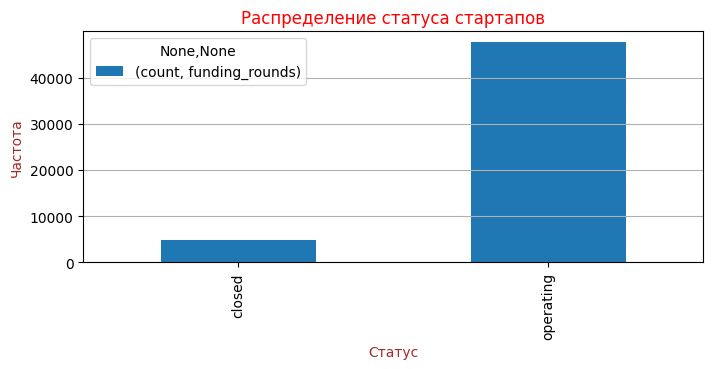

In [36]:
ax =( df_train.pivot_table(index= 'status',values = 'funding_rounds',aggfunc=['count'])
     .plot(kind = 'bar', figsize = (8,3),rot = 90, legend = True, fontsize = 10)
);
ax.yaxis.grid()
ax.set_xlabel("Статус",fontsize = 10, color = 'Brown')
ax.set_ylabel("Частота",fontsize = 10, color = 'Brown')
ax.set_title("Распределение статуса стартапов",fontsize = 12, color = 'Red' );

In [37]:
df_train['status'].value_counts()

status
operating    47599
closed        4917
Name: count, dtype: int64

Из распределения видим что данные целевого признака несбалансированы, количество действующих стартапов на порядок выше 

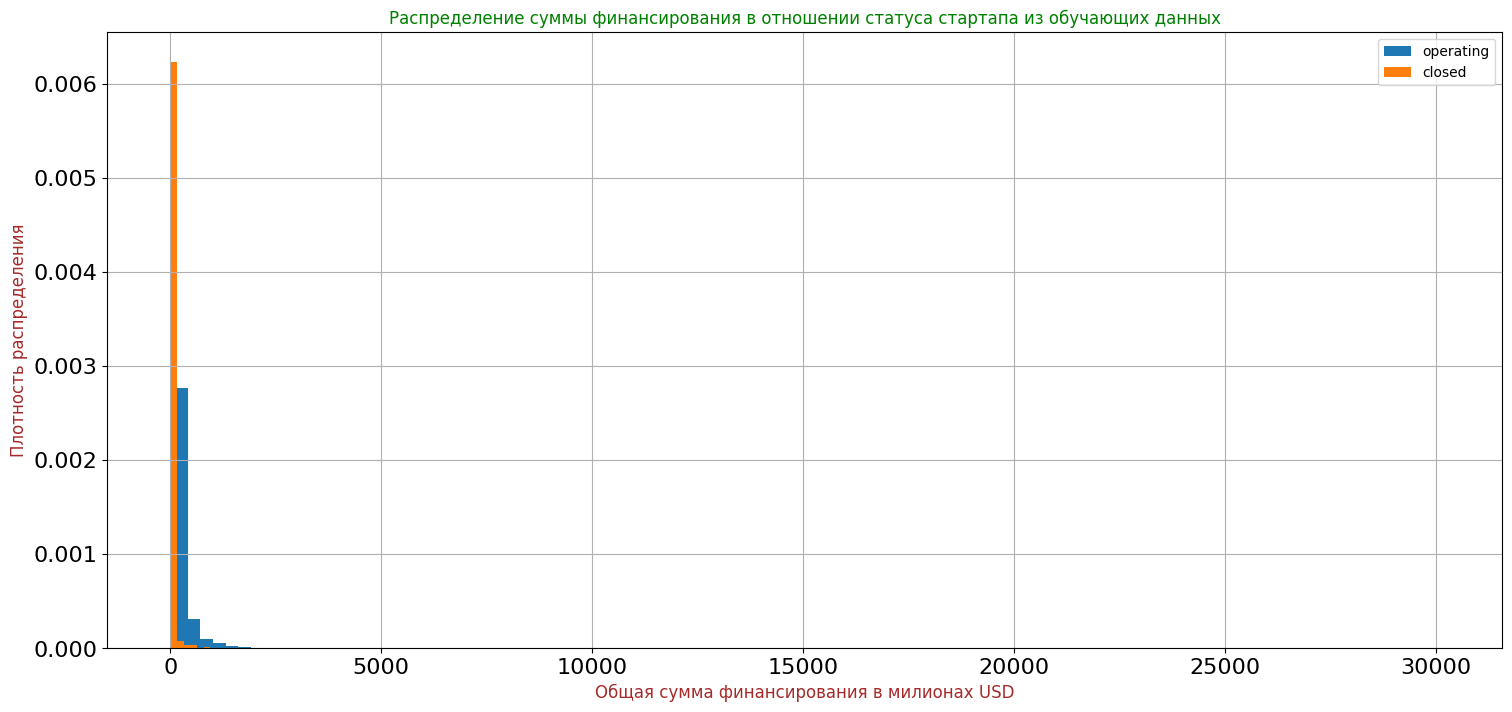

In [38]:
ax =( (df_train
     .query('status == "operating"')['funding_total_usd']/1000000).sort_values(ascending=False).head(1000)
     .plot(kind = 'hist', density=True, figsize = (18,8),bins = 100, fontsize = 16, legend = True, label="operating")
);
ax =( (df_train
     .query('status == "closed"')['funding_total_usd']/1000000).sort_values(ascending=False).head(1000)
     .plot(kind = 'hist', density=True, figsize = (18,8),bins = 10, fontsize = 16, legend = True, label="closed")
    );


ax.grid()
ax.set_xlabel("Общая сумма финансирования в милионах USD",fontsize = 12, color = 'Brown')
ax.set_ylabel("Плотность распределения",fontsize = 12, color = 'Brown')
ax.set_title("Распределение суммы финансирования в отношении статуса стартапа из обучающих данных",fontsize = 12, color = 'Green' );

Видим что гистограмма растянута вправо, есть выбросы с большими суммами финансирования, посмотрим на гистаграмму без выбросов. 

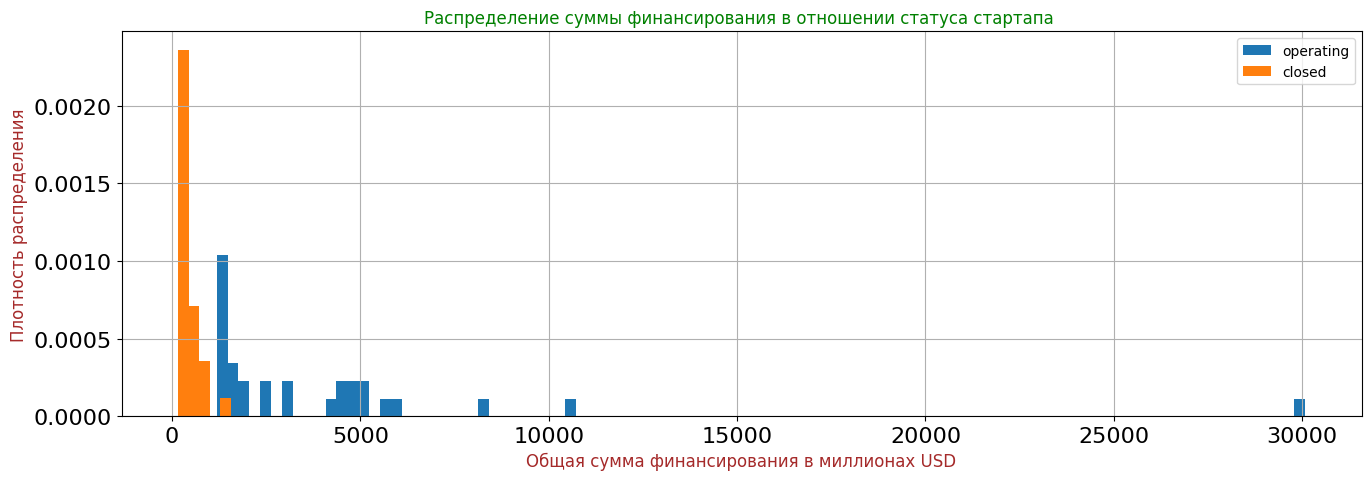

In [39]:
ax =( (df_train
     .query('status == "operating"')['funding_total_usd']/1000000).sort_values(ascending=False).head(30)
     .plot(kind = 'hist', density=True, figsize = (16,5),bins = 100, fontsize = 16, legend = True, label="operating")
);
ax =( (df_train
     .query('status == "closed"')['funding_total_usd']/1000000).sort_values(ascending=False).head(30)
     .plot(kind = 'hist', density=True, figsize = (16,5),bins = 5, fontsize = 16, legend = True, label="closed")
    );


ax.grid()
ax.set_xlabel("Общая сумма финансирования в миллионах USD",fontsize = 12, color = 'Brown')
ax.set_ylabel("Плотность распределения",fontsize = 12, color = 'Brown')
ax.set_title("Распределение суммы финансирования в отношении статуса стартапа ",fontsize = 12, color = 'Green' );

Видим, что стартапы с большой суммой финансирования, после определенного значения всегда на плаву.


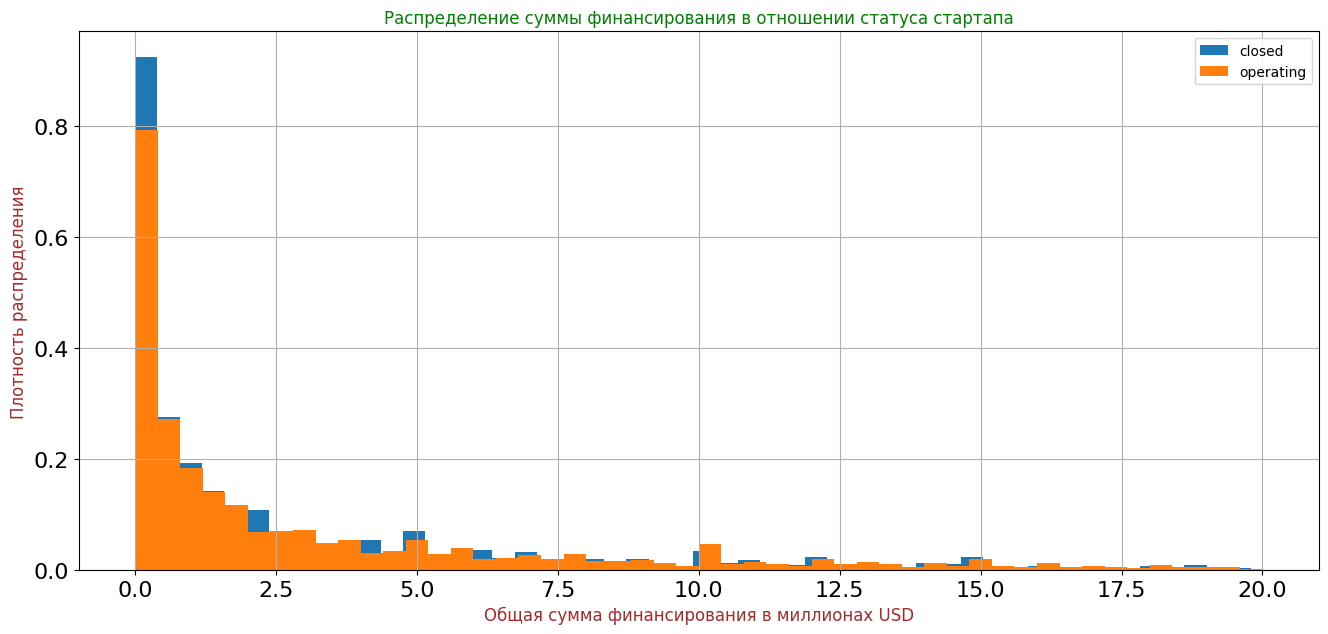

In [40]:

ax =( (df_train
     .query('status == "closed" and funding_total_usd < 20000000')['funding_total_usd']/1000000)
     .plot(kind = 'hist', density=True, figsize = (16,7),bins = 50, fontsize = 16, legend = True, label="closed")
    );
ax =( (df_train
     .query('status == "operating" and funding_total_usd < 20000000')['funding_total_usd']/1000000)
     .plot(kind = 'hist', density=True, figsize = (16,7),bins = 50, fontsize = 16, legend = True, label="operating")
);

ax.grid()
ax.set_xlabel("Общая сумма финансирования в миллионах USD",fontsize = 12, color = 'Brown')
ax.set_ylabel("Плотность распределения",fontsize = 12, color = 'Brown')
ax.set_title("Распределение суммы финансирования в отношении статуса стартапа",fontsize = 12, color = 'Green' );

Распределение имеет вид убывающей экспоненты. Для действующих и закрытых стартапов распределение схожее. Но для действующих стартапов оно более растянуто по выбросам больших сумм финансирования.Основная часть финансирования находится в пределах 20 миллионов USD. Посмотрим на топ 30 стартапов по сумме финансирования. 

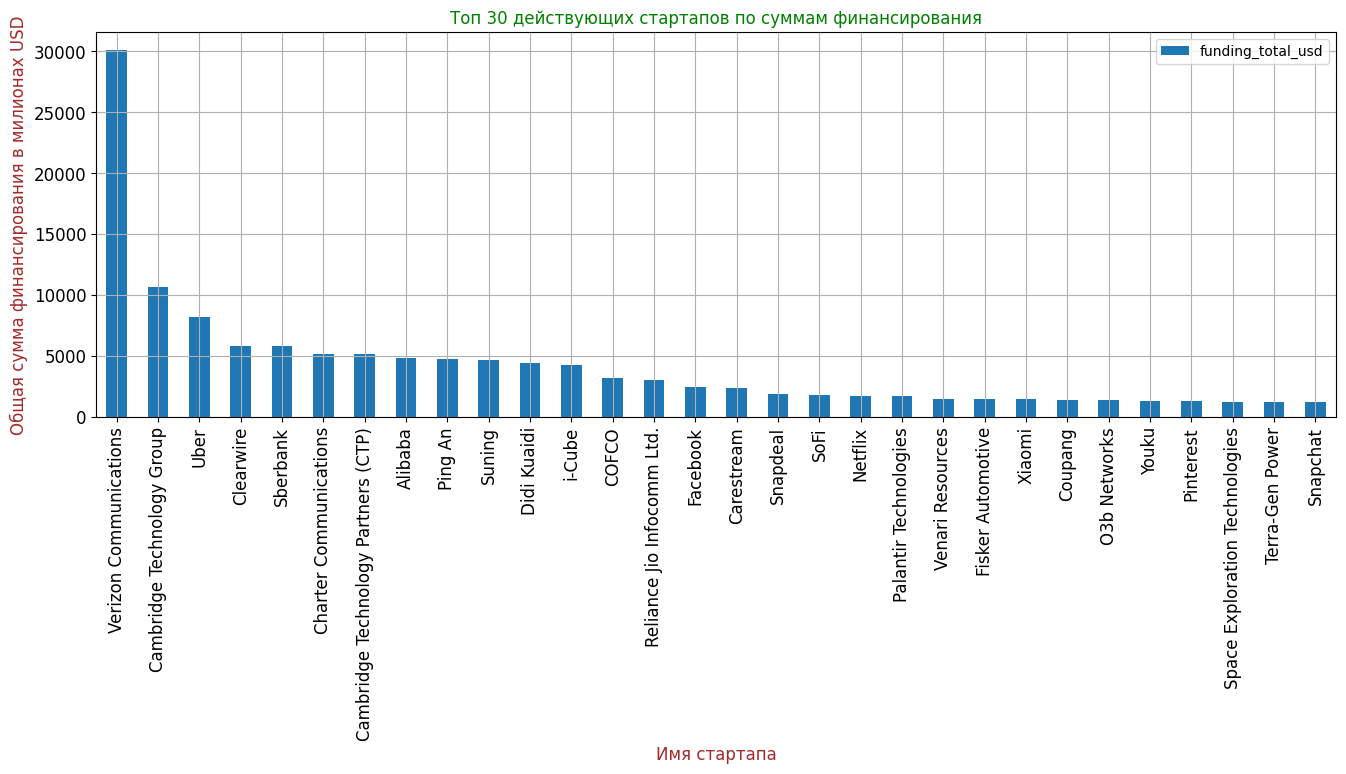

In [41]:
ax =( (df_train.query('status == "operating"')['funding_total_usd']/1000000).sort_values(ascending=False).head(30)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12)
    );

ax.grid()
ax.set_xlabel("Имя стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Общая сумма финансирования в милионах USD",fontsize = 12, color = 'Brown')
ax.set_title("Топ 30 действующих стартапов по суммам финансирования",fontsize = 12, color = 'Green' );

В лидерах много известных компаний - Веризон, Uber, Сбербанк, Алибаба, Фейсбук, Нетфликс, Xiaomi.

Посмотрим на топ закрытых стартапов по сумме финансирования

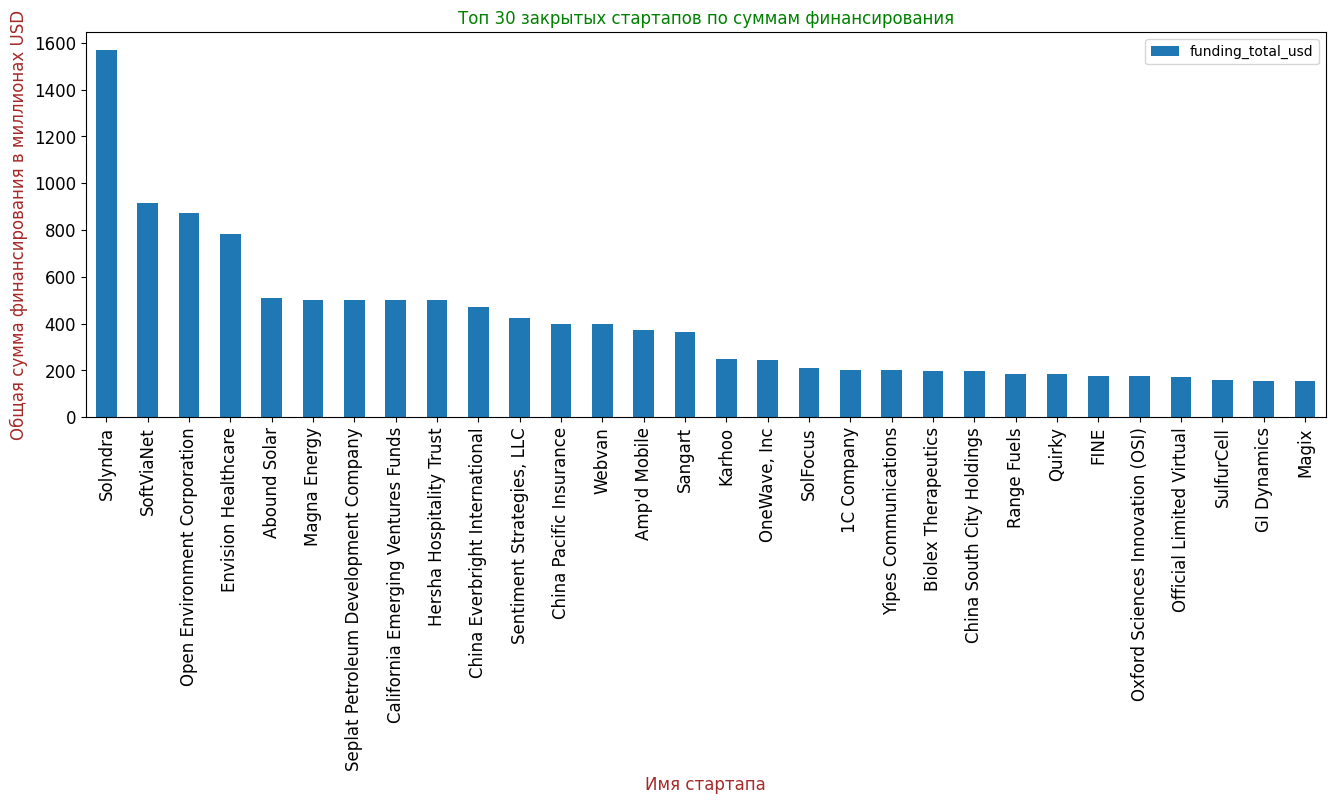

In [42]:
ax =( (df_train.query('status == "closed"')['funding_total_usd']/1000000).sort_values(ascending=False).head(30)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12)
    );


ax.set_xlabel("Имя стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Общая сумма финансирования в миллионах USD",fontsize = 12, color = 'Brown')
ax.set_title("Топ 30 закрытых стартапов по суммам финансирования",fontsize = 12, color = 'Green' );

Графики закрытых и открытых стартапов по топ финансированию похожи друг на друга, отличие в сумме финансирования, для закрытых стартапов сумма финансирования намного меньше.

In [43]:
df_train_piv_sum = df_train.pivot_table(index= 'cat_0', columns= 'status',values = 'funding_total_usd',aggfunc=['sum'])/1000000
df_train_piv_mean_median = df_train.pivot_table(index= 'cat_0', columns= 'status', values = 'funding_total_usd',aggfunc=['mean', 'median'])/1000000

df_train_piv_sum.columns = ['sum_closed', 'sum_operating']

In [44]:
df_train_piv_mean_median.columns = ['mean_closed', 'mean_operating', 'median_closed', 'median_operating']
df_train_piv_mean_median['mean_rate_op_to_cl'] = df_train_piv_mean_median['mean_operating']/df_train_piv_mean_median['mean_closed']
df_train_piv_mean_median['median_rate_op_to_cl'] = df_train_piv_mean_median['median_operating']/df_train_piv_mean_median['median_closed']

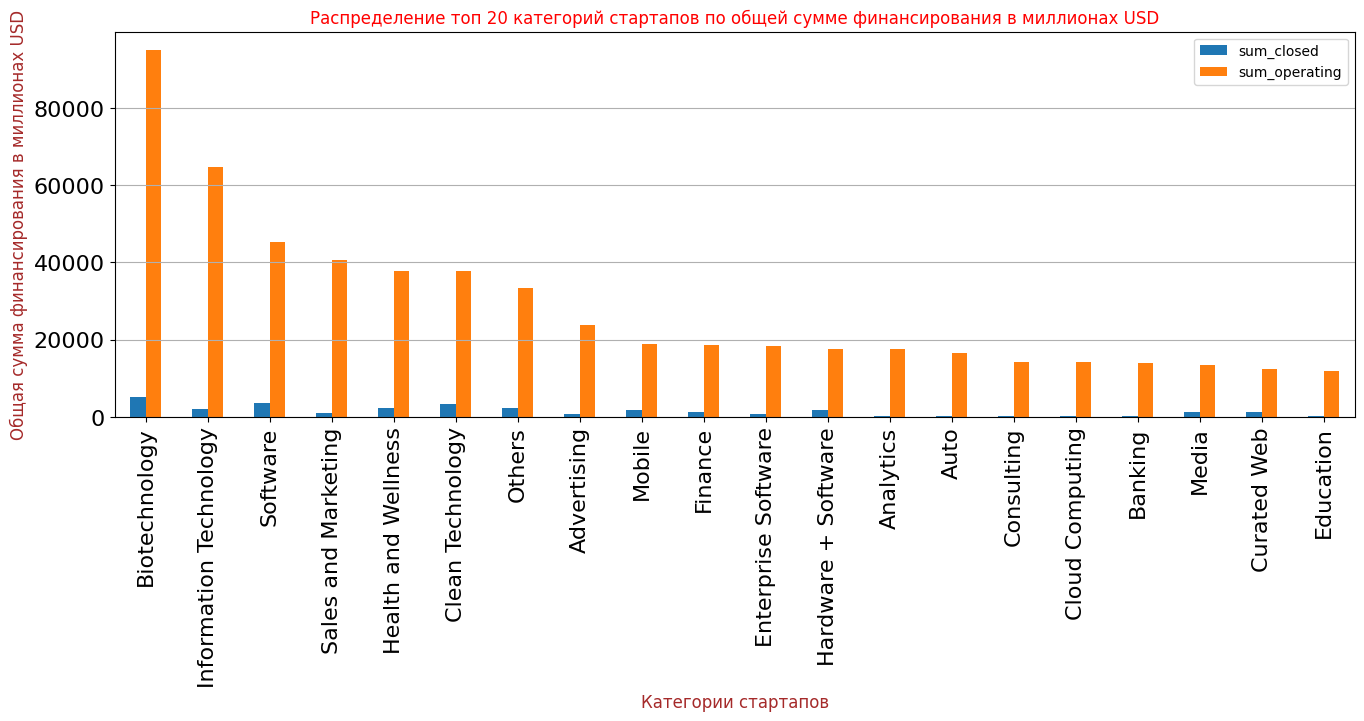

In [45]:
ax =( df_train_piv_sum.sort_values(by ='sum_operating',ascending=False).head(20)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 16)
);
ax.yaxis.grid()
ax.set_xlabel("Категории стартапов",fontsize = 12, color = 'Brown')
ax.set_ylabel("Общая сумма финансирования в миллионах USD",fontsize = 12, color = 'Brown')
ax.set_title("Распределение топ 20 категорий стартапов по общей сумме финансирования в миллионах USD",fontsize = 12, color = 'Red' );

Как видим из графика больше всего финансируют биотехнологии, информационные технологии, програмное обеспечение, продажи и маркетинг и здоровье

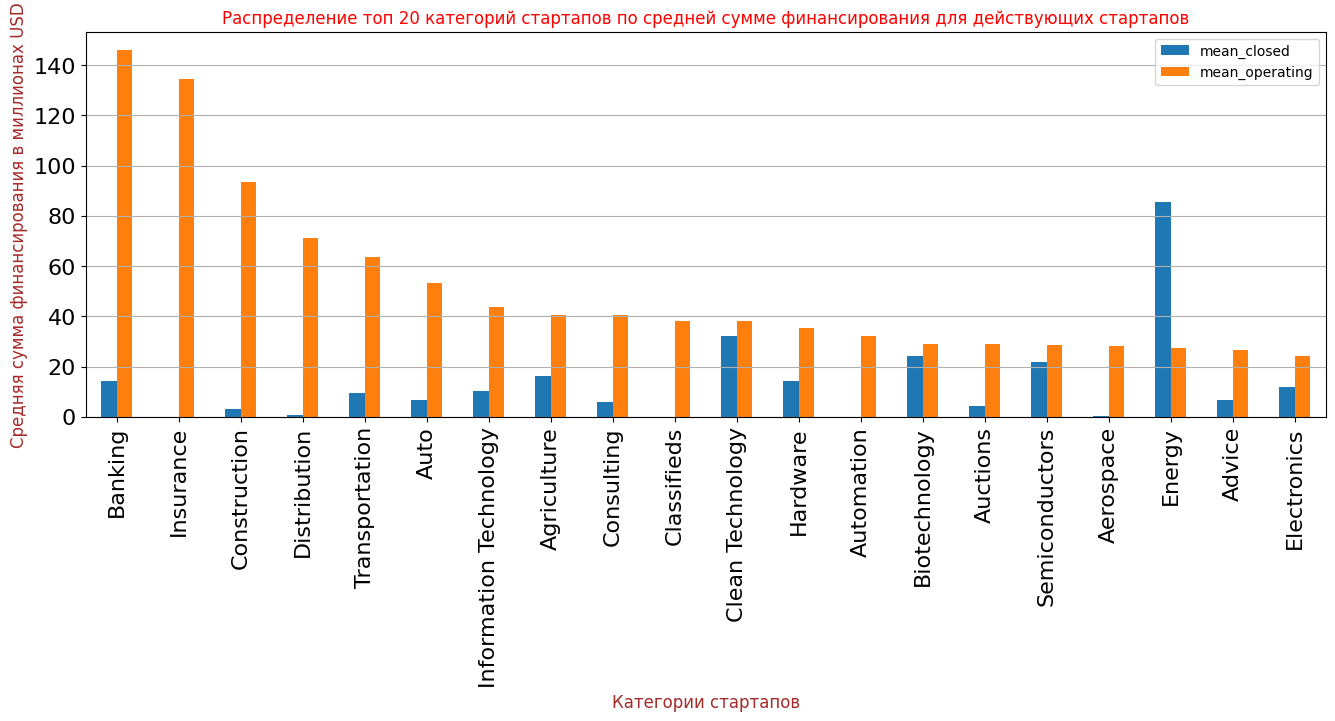

In [46]:
ax =( df_train_piv_mean_median[['mean_closed', 'mean_operating']].sort_values(by =['mean_operating','mean_closed'],ascending=False).head(20)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 16)
);
ax.yaxis.grid()
ax.set_xlabel("Категории стартапов",fontsize = 12, color = 'Brown')
ax.set_ylabel("Средняя сумма финансирования в миллионах USD",fontsize = 12, color = 'Brown')
ax.set_title("Распределение топ 20 категорий стартапов по средней сумме финансирования для действующих стартапов",fontsize = 12, color = 'Red' );

Из графика видно, что в основном средняя сумма финансирования у открытого проекта выше чем у закрытого, но есть и исключения, такие как категория Energy. Скорее всего тонущие стартапы пытаются спасти путем дополнительного финансирования либо это жизненно важные категории
Посмотрим на такие категории

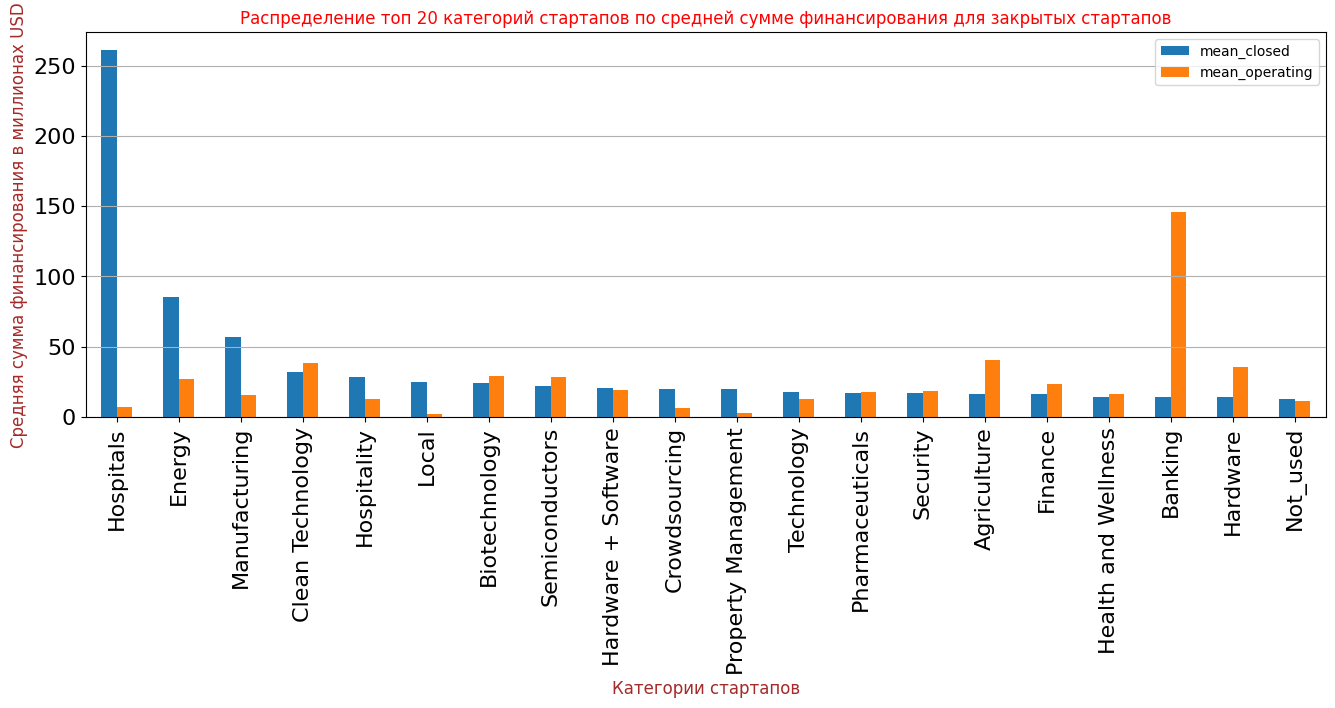

In [47]:
ax =( df_train_piv_mean_median[['mean_closed', 'mean_operating']].sort_values(by =['mean_closed','mean_operating'],ascending=False).head(20)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 16)
);
ax.yaxis.grid()
ax.set_xlabel("Категории стартапов",fontsize = 12, color = 'Brown')
ax.set_ylabel("Средняя сумма финансирования в миллионах USD",fontsize = 12, color = 'Brown')
ax.set_title("Распределение топ 20 категорий стартапов по средней сумме финансирования для закрытых стартапов",fontsize = 12, color = 'Red' );

Как водим из графиков это больницы, энергетика, производство, гостепреимство, проперти менеждемент и фармацевтика

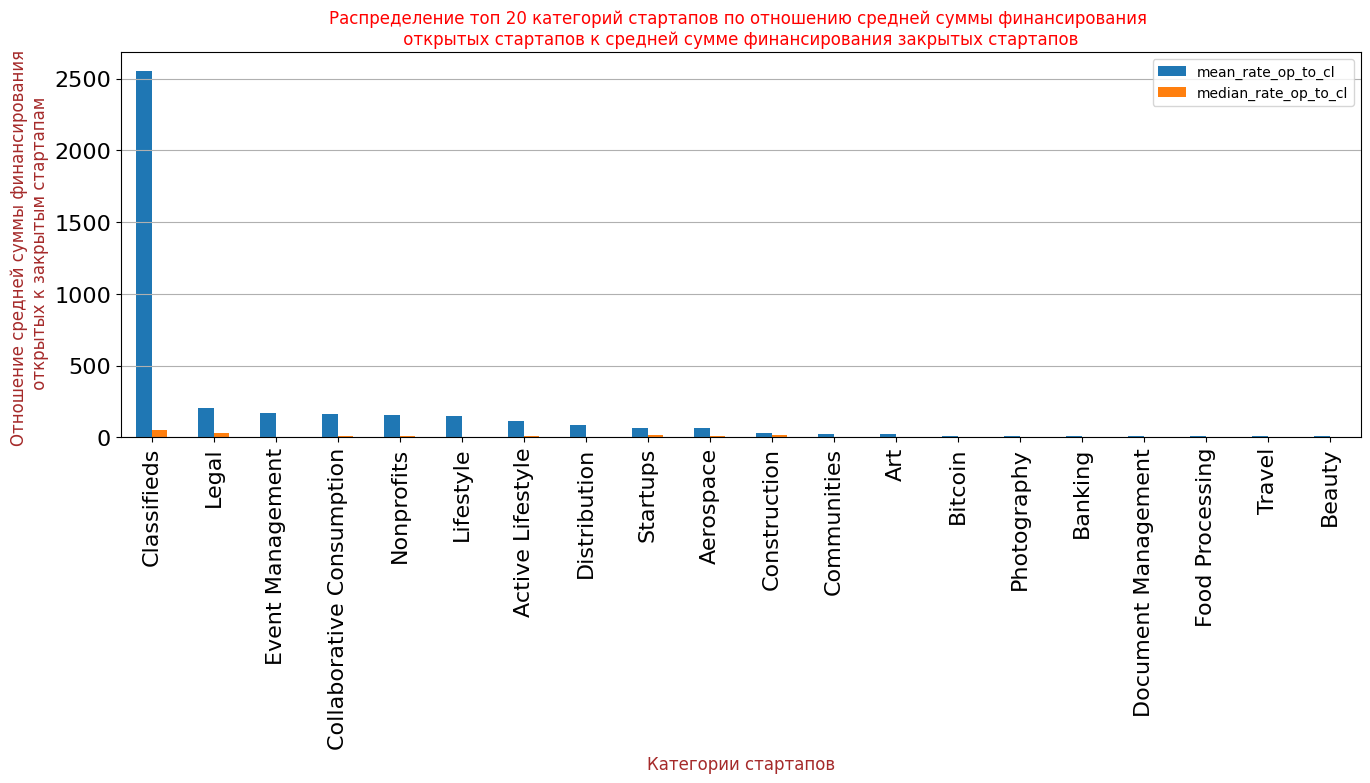

In [48]:
ax =( df_train_piv_mean_median[['mean_rate_op_to_cl', 'median_rate_op_to_cl']].sort_values(by =['mean_rate_op_to_cl','median_rate_op_to_cl'],ascending=False).head(20)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 16)
);
ax.yaxis.grid()
ax.set_xlabel("Категории стартапов",fontsize = 12, color = 'Brown')
ax.set_ylabel("Отношение средней суммы финансирования \n открытых к закрытым стартапам",fontsize = 12, color = 'Brown')
ax.set_title("Распределение топ 20 категорий стартапов по отношению средней суммы финансирования \n открытых стартапов к средней сумме финансирования закрытых стартапов ",fontsize = 12, color = 'Red' );

Из графика видим категории стартапов, живучесть которых сильно зависит от вложенного финансирования и самая высокая отдача у КЛАССИФИКАЦИИ, как раз с чем мы боремся на данном проекте!!!:):):) Посмотрим на медианные значения ввиду больших скачков у средних значений  

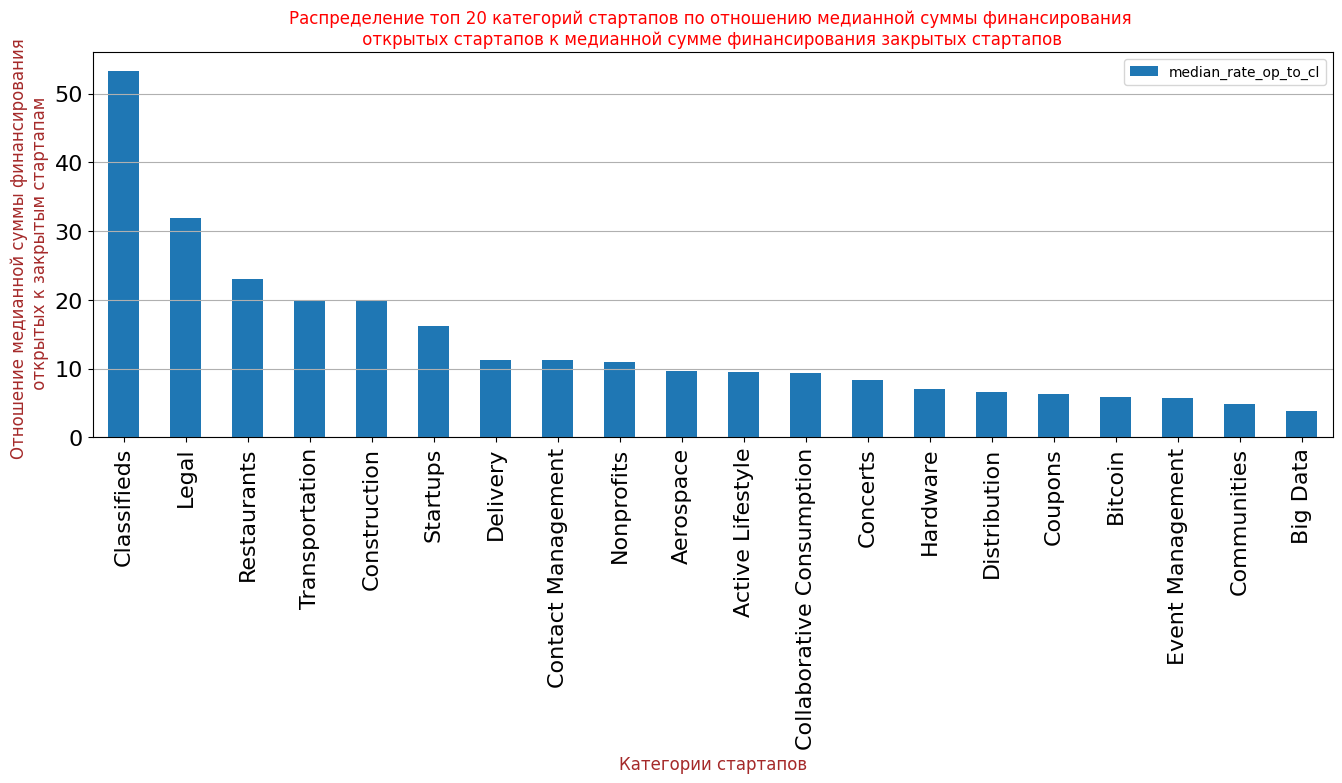

In [49]:
ax =( df_train_piv_mean_median['median_rate_op_to_cl'].sort_values(ascending=False).head(20)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 16)
);
ax.yaxis.grid()
ax.set_xlabel("Категории стартапов",fontsize = 12, color = 'Brown')
ax.set_ylabel("Отношение медианной суммы финансирования \n открытых к закрытым стартапам",fontsize = 12, color = 'Brown')
ax.set_title("Распределение топ 20 категорий стартапов по отношению медианной суммы финансирования \n открытых стартапов к медианной сумме финансирования закрытых стартапов ",fontsize = 12, color = 'Red' );

В лидерах классификация, кроудфандинг и аппаратное обеспечение, далее Юриспруденция и финансовые технологии, 
в десятку входит big data

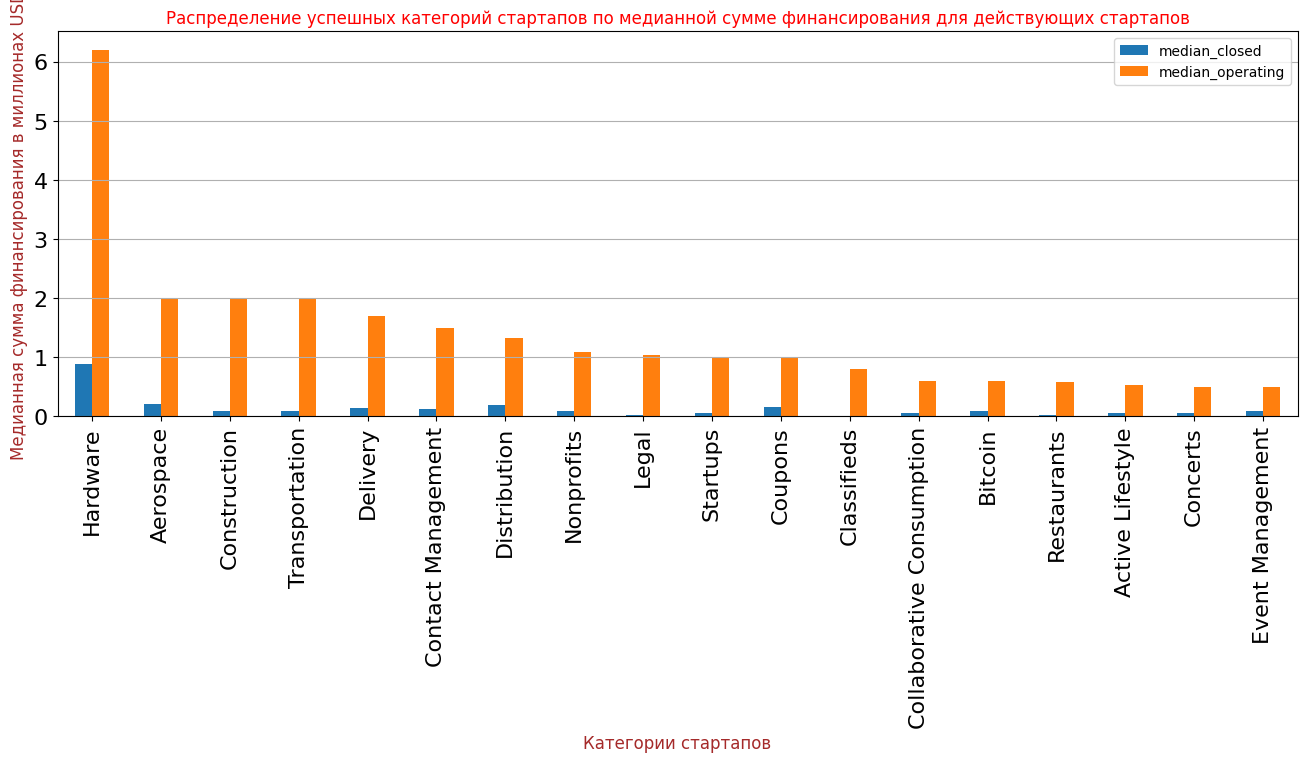

In [50]:
ax =( df_train_piv_mean_median.query('median_rate_op_to_cl > 5')[['median_closed', 'median_operating']].sort_values(by =['median_operating','median_closed'],ascending=False).head(20)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 16)
);
ax.yaxis.grid()
ax.set_xlabel("Категории стартапов",fontsize = 12, color = 'Brown')
ax.set_ylabel("Медианная сумма финансирования в миллионах USD",fontsize = 12, color = 'Brown')
ax.set_title("Распределение успешных категорий стартапов по медианной сумме финансирования для действующих стартапов",fontsize = 12, color = 'Red' );

Медианная сумма финансирования для классификации составляет менее миллиона долларов.
Чтобы открыть ресторан достаточно чуть больше пол миллиона долларов
Для юридической конторы тоже достаточно миллиона долларов

 Посмотрим на топ 30 стран по стартапам

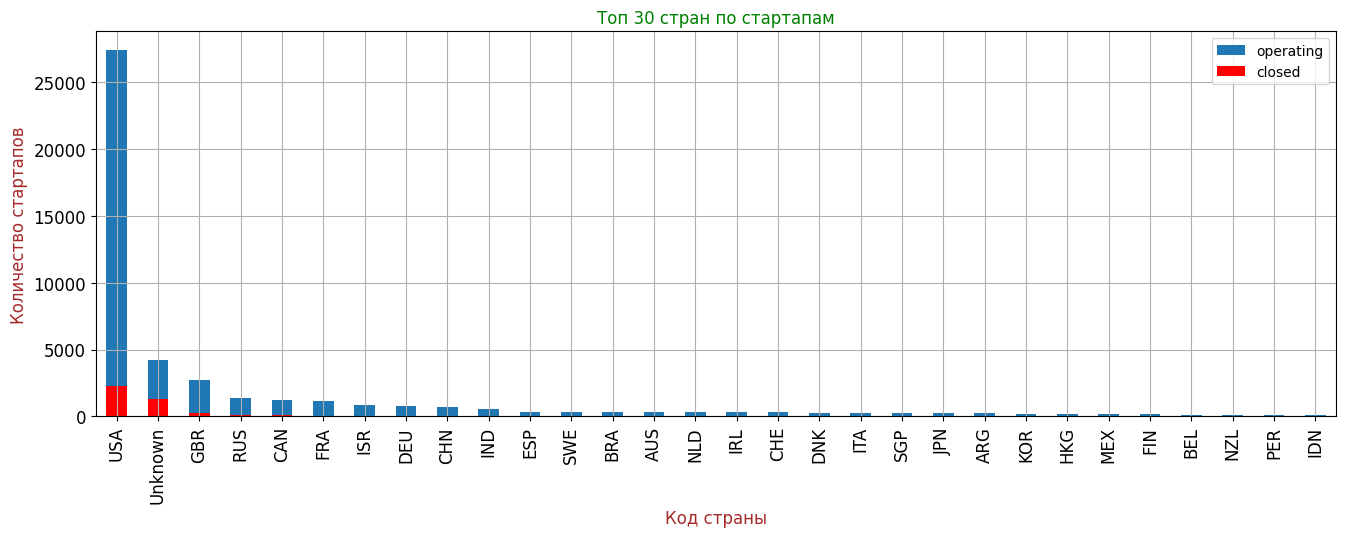

In [51]:
#df_train.query('status == "operating"')['country_code'].value_counts(ascending=False).head(30)
ax =( df_train.query('status == "operating"')['country_code'].value_counts(ascending=False).head(30)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12, label="operating")
    );
ax =( df_train.query('status == "closed"')['country_code'].value_counts(ascending=False).head(30)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12, color = "r", label="closed")
    );
ax.grid()
ax.set_xlabel("Код страны",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Топ 30 стран по стартапам",fontsize = 12, color = 'Green' );

На первом месте по количеству стартапов с большим отрывом лидируют США, на втором месте Великобритания, на третьем месте Россия, на четвертом Канада и на пятом месте Франция

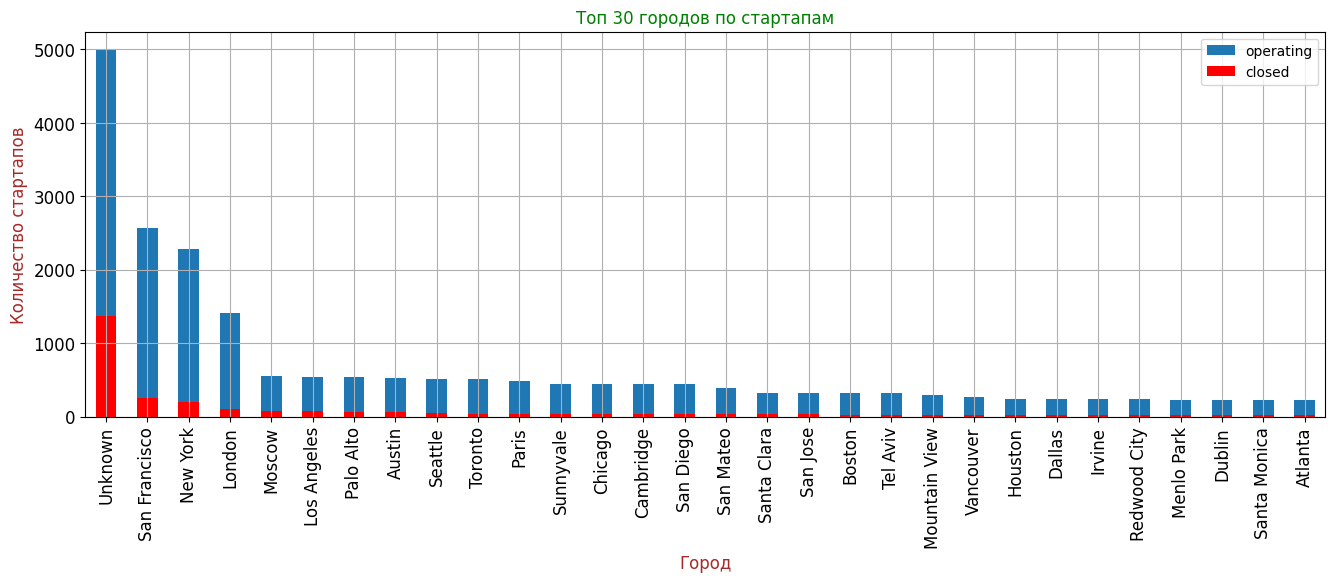

In [52]:
ax =( df_train.query('status == "operating"')['city'].value_counts(ascending=False).head(30)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12, label="operating")
    );
ax =( df_train.query('status == "closed"')['city'].value_counts(ascending=False).head(30)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12, color = "r", label="closed")
    );
ax.grid()
ax.set_xlabel("Город",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Топ 30 городов по стартапам",fontsize = 12, color = 'Green' );

На первом месте лидирует Сан Франциско, на втором Нью Йорк, на третьем Лондон, на четвертом Москва и на пятом Лос Анжелес

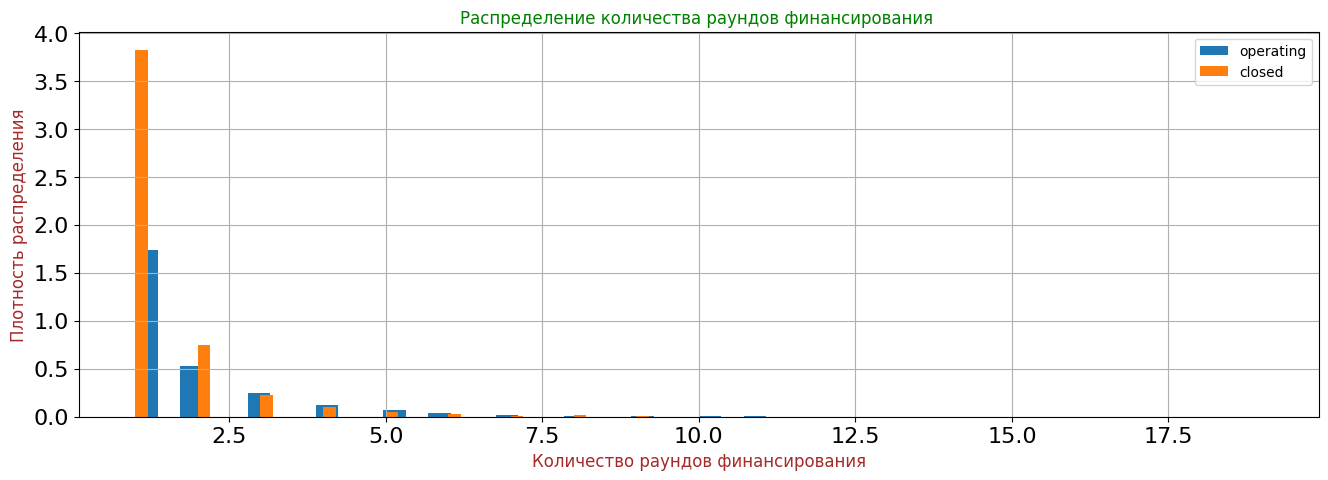

In [53]:
ax =( df_train
     .query('status == "operating"')['funding_rounds']
     .plot(kind = 'hist',density=True, figsize = (16,5),bins = 50, fontsize = 16, legend = True, label="operating")
);
ax =( df_train
     .query('status == "closed"')['funding_rounds']
     .plot(kind = 'hist', density=True, figsize = (16,5),bins = 50, fontsize = 16, legend = True, label="closed")
    );


ax.grid()
ax.set_xlabel("Количество раундов финансирования",fontsize = 12, color = 'Brown')
ax.set_ylabel("Плотность распределения",fontsize = 12, color = 'Brown')
ax.set_title("Распределение количества раундов финансирования ",fontsize = 12, color = 'Green' );

Большинство стартапов было только с одним раундом и только один с 19 раундами. Распределение имеет вид убывающей экспоненты

In [54]:
df_train.query('status == "operating"')['funding_rounds'].value_counts()

funding_rounds
1     29730
2      9076
3      4230
4      2090
5      1123
6       591
7       332
8       162
9       105
10       62
11       44
12       22
13        9
16        6
15        5
14        5
17        3
18        3
19        1
Name: count, dtype: int64

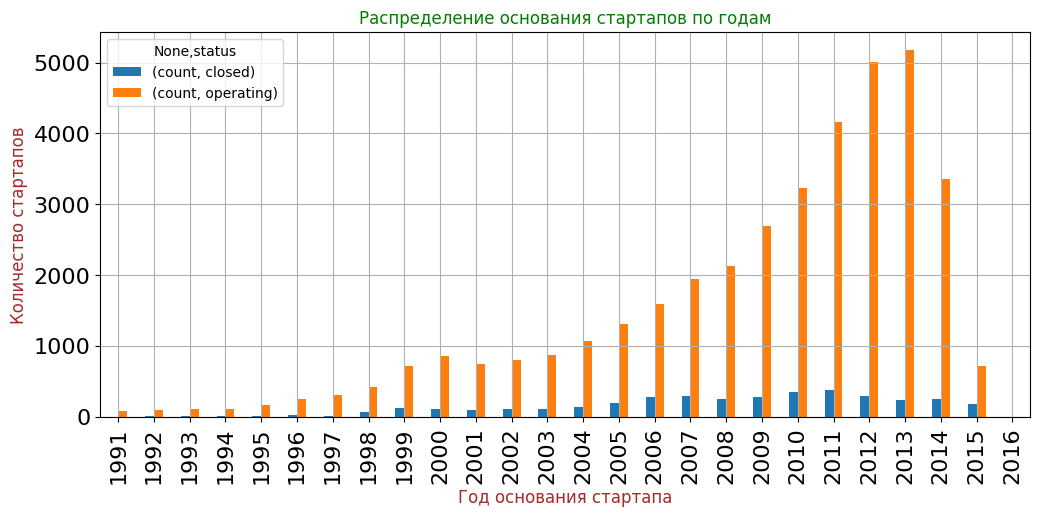

In [55]:

ax =( df_train.query('founded_at_year > 1990').pivot_table(index= 'founded_at_year', columns= 'status',values = 'funding_total_usd',aggfunc=['count'])
     .plot(kind = 'bar', figsize = (12,5),rot = 90, legend = True, fontsize = 16)
    );
ax.grid()
ax.set_xlabel("Год основания стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Распределение основания стартапов по годам",fontsize = 12, color = 'Green' );

Видим что количество стартапов из года в год экспоненциально растет. При этом закрытые стартапы не имеют такого сильного роста. После 2013г наблюдается резкий спад роста стартапов.Также есть волны,примерно раз в 10 лет, предположительно они связаны с финансовыми кризисами

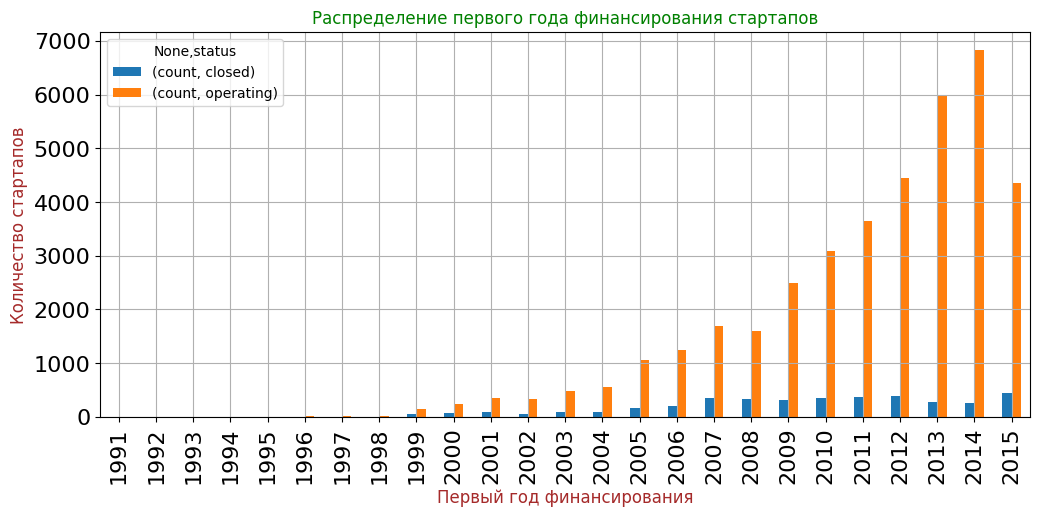

In [56]:

ax =( df_train.query('first_funding_at_year > 1990').pivot_table(index= 'first_funding_at_year', columns= 'status',values = 'funding_total_usd',aggfunc=['count'])
     .plot(kind = 'bar', figsize = (12,5),rot = 90, legend = True, fontsize = 16)
    );
ax.grid()
ax.set_xlabel("Первый год финансирования",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Распределение первого года финансирования стартапов",fontsize = 12, color = 'Green' );

Первый год финансирования также имеет вид возрастающей экспоненты с волнами.

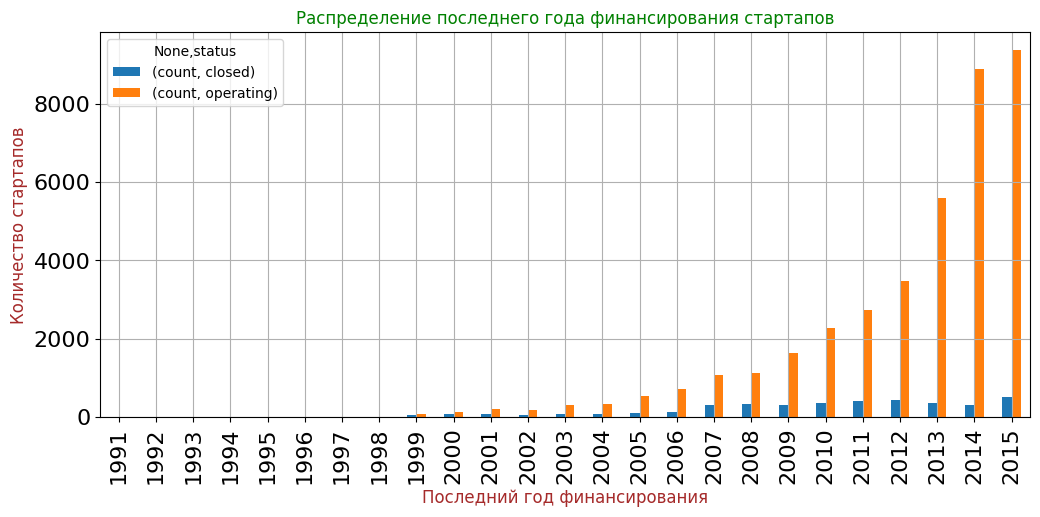

In [57]:

ax =( df_train.query('last_funding_at_year > 1990').pivot_table(index= 'last_funding_at_year', columns= 'status',values = 'funding_total_usd',aggfunc=['count'])
     .plot(kind = 'bar', figsize = (12,5),rot = 90, legend = True, fontsize = 16)
    );
ax.grid()
ax.set_xlabel("Последний год финансирования",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Распределение последнего года финансирования стартапов",fontsize = 12, color = 'Green' );

Распределение по первому и последнему году финансирования схожее с распределением года основания стартапа

In [58]:
df_train.query('status == "operating"')['closed_at'].value_counts(ascending=False).head(30)

Series([], Name: count, dtype: int64)

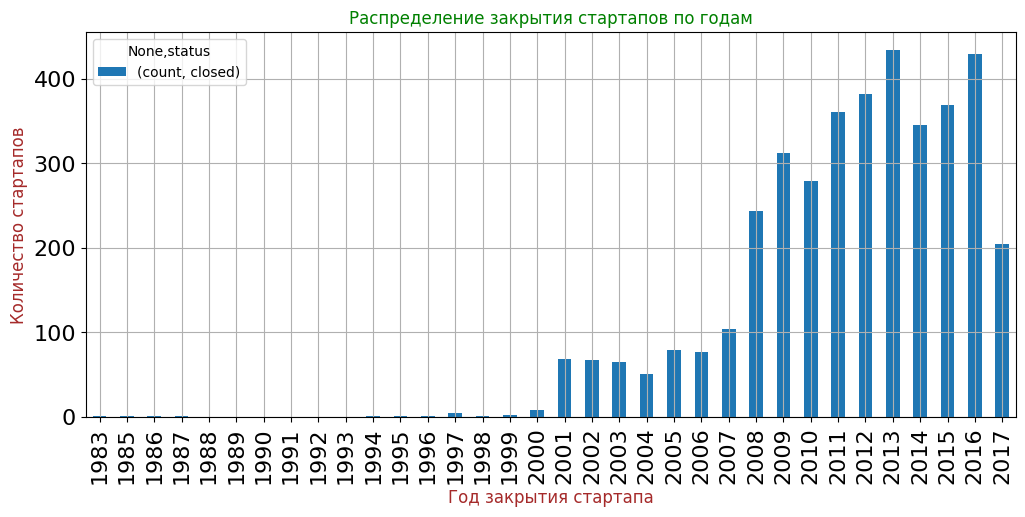

In [59]:
#ax =( df_train.query('status == "operating" and ~closed_at.isna()')['closed_at'].value_counts(ascending=False).head(30)
#     .plot(kind = 'bar', figsize = (18,10),rot = 90, legend = True, fontsize = 12, label="operating")
#    );
df_train['closed_at_year'] = df_train['closed_at_year'].astype('Int64')
ax =( df_train.query('status == "closed" and ~closed_at.isna()').pivot_table(index= 'closed_at_year', columns= 'status',values = 'funding_total_usd',aggfunc=['count'])
     .plot(kind = 'bar', figsize = (12,5),rot = 90, legend = True, fontsize = 16));
ax.grid()
ax.set_xlabel("Год закрытия стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Распределение закрытия стартапов по годам",fontsize = 12, color = 'Green' );

Распределение года закрытия стартапа более пологое чем распределение года основания стартапа.
Посмотрим на топ категорий стартапа

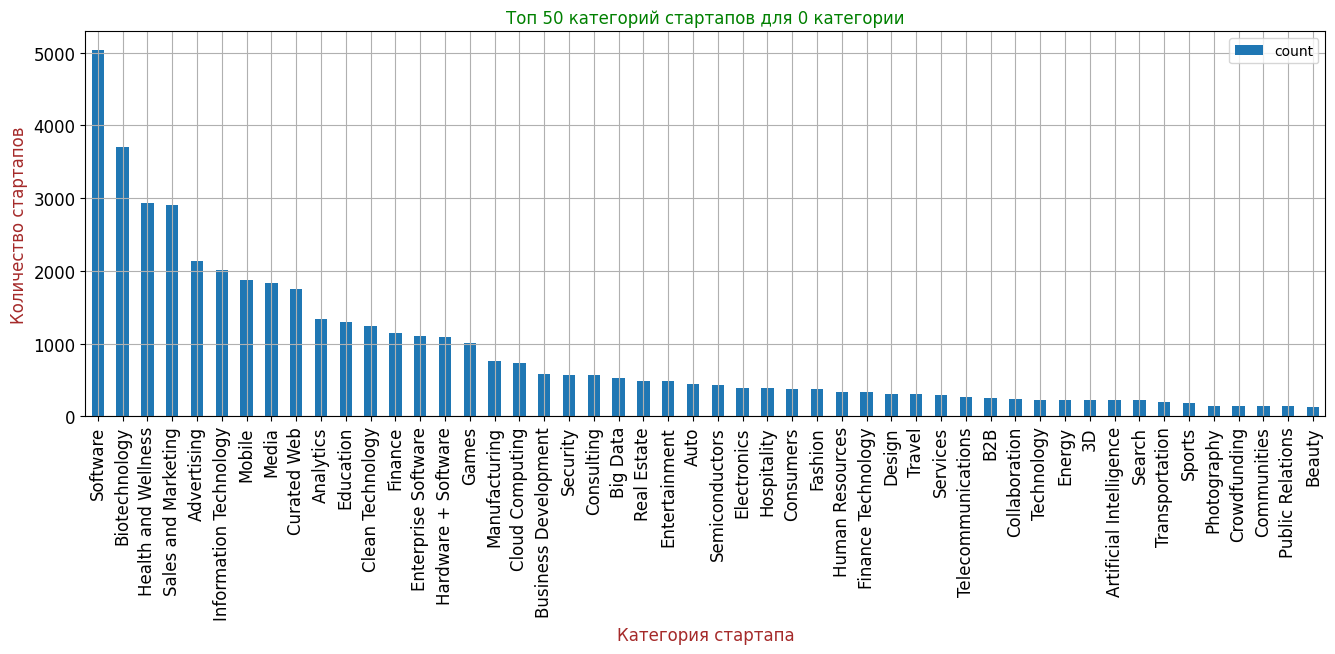

In [60]:
ax =( df_train.query('cat_0 != "Not_used" and cat_0 != "Others"')['cat_0'].value_counts(ascending=False).head(50)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12)
    );

ax.grid()
ax.set_xlabel("Категория стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Топ 50 категорий стартапов для 0 категории",fontsize = 12, color = 'Green' );

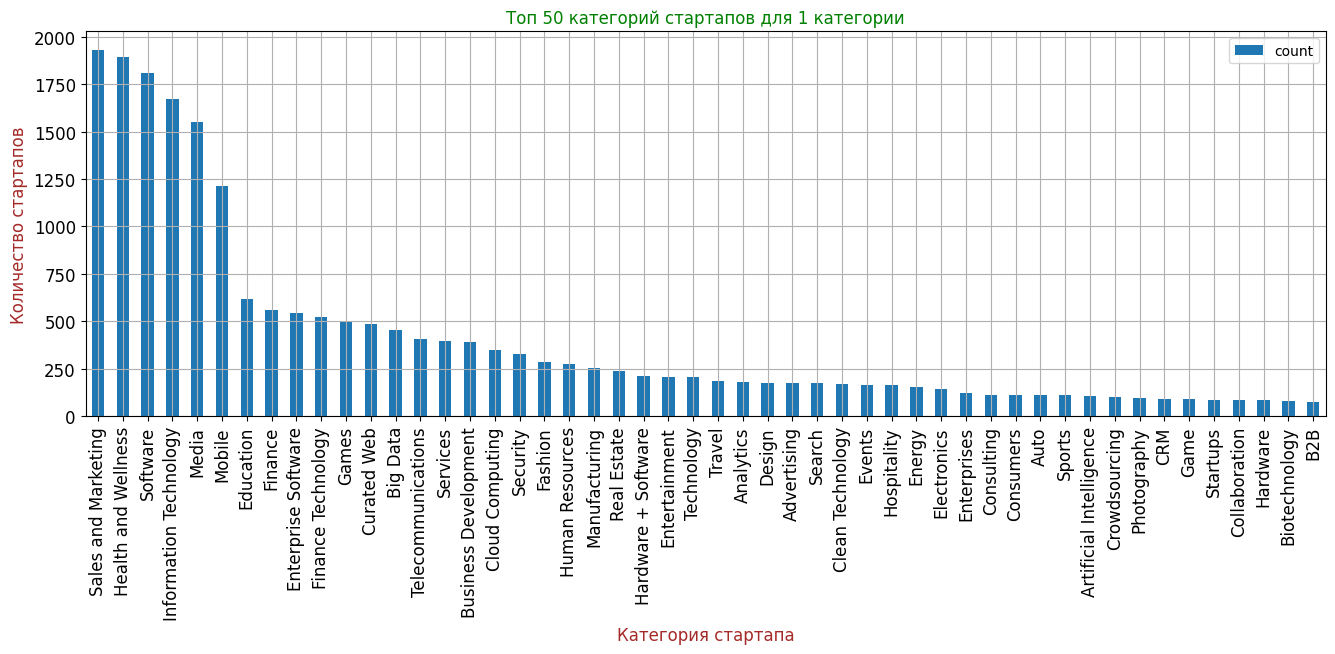

In [61]:
ax =( df_train.query('cat_1 != "Not_used" and cat_1 != "Others"')['cat_1'].value_counts(ascending=False).head(50)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12)
    );


ax.grid()
ax.set_xlabel("Категория стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Топ 50 категорий стартапов для 1 категории",fontsize = 12, color = 'Green' );

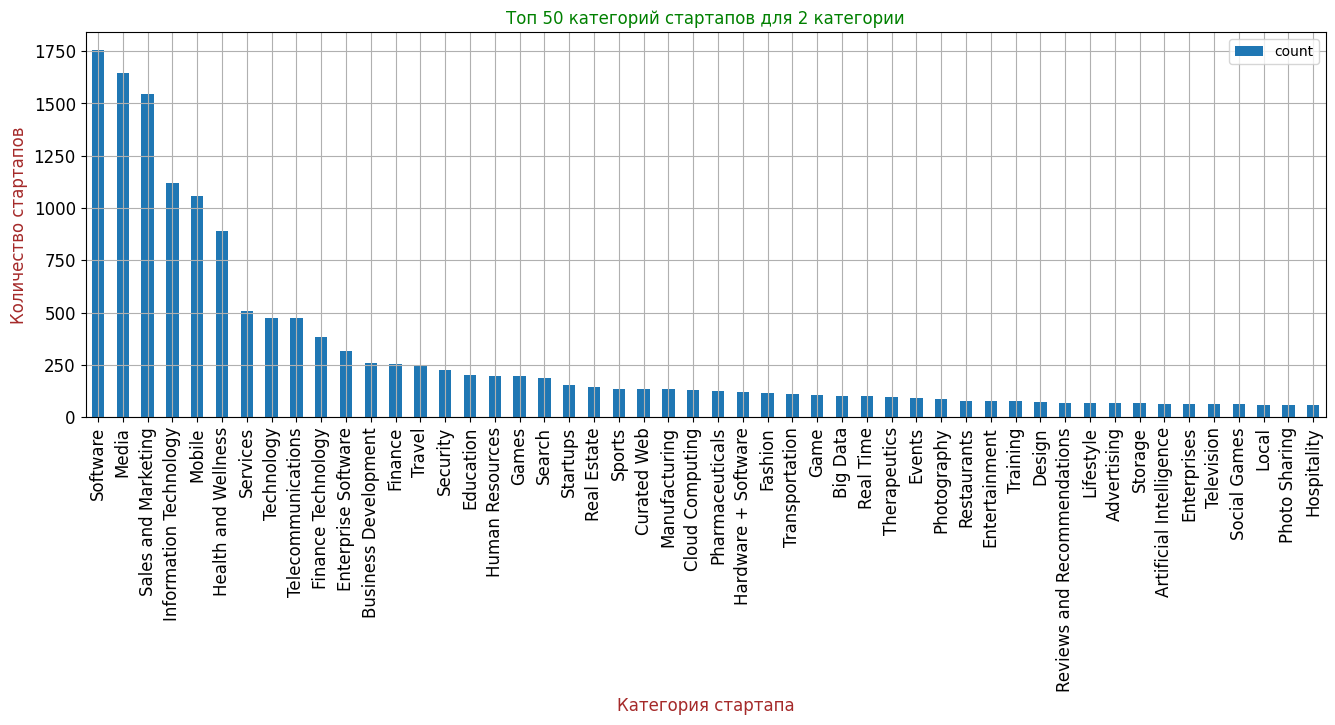

In [62]:
ax =( df_train.query('cat_2 != "Not_used" and cat_2 != "Others"')['cat_2'].value_counts(ascending=False).head(50)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12)
    );

ax.grid()
ax.set_xlabel("Категория стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Топ 50 категорий стартапов для 2 категории",fontsize = 12, color = 'Green' );

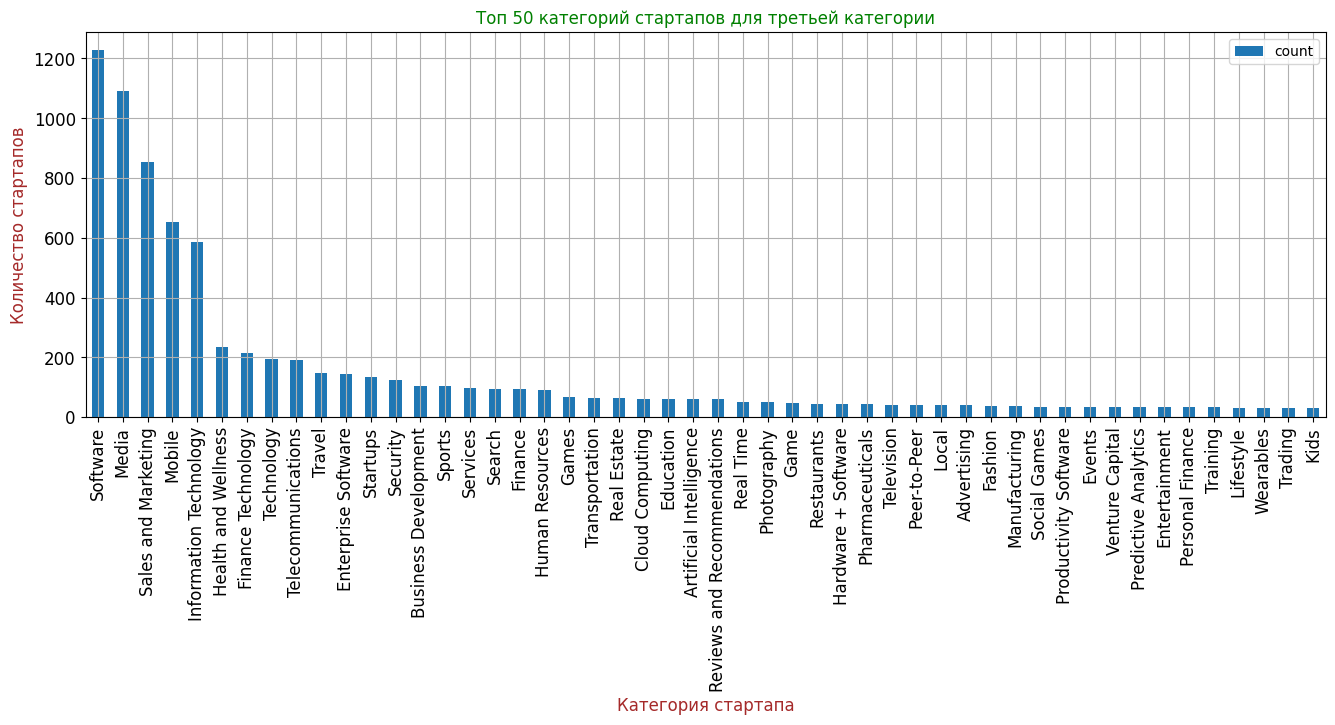

In [63]:
ax =( df_train.query('cat_3 != "Not_used" and cat_3 != "Others" ')['cat_3'].value_counts(ascending=False).head(50)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12)
    );

ax.grid()
ax.set_xlabel("Категория стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Топ 50 категорий стартапов для третьей категории",fontsize = 12, color = 'Green' );

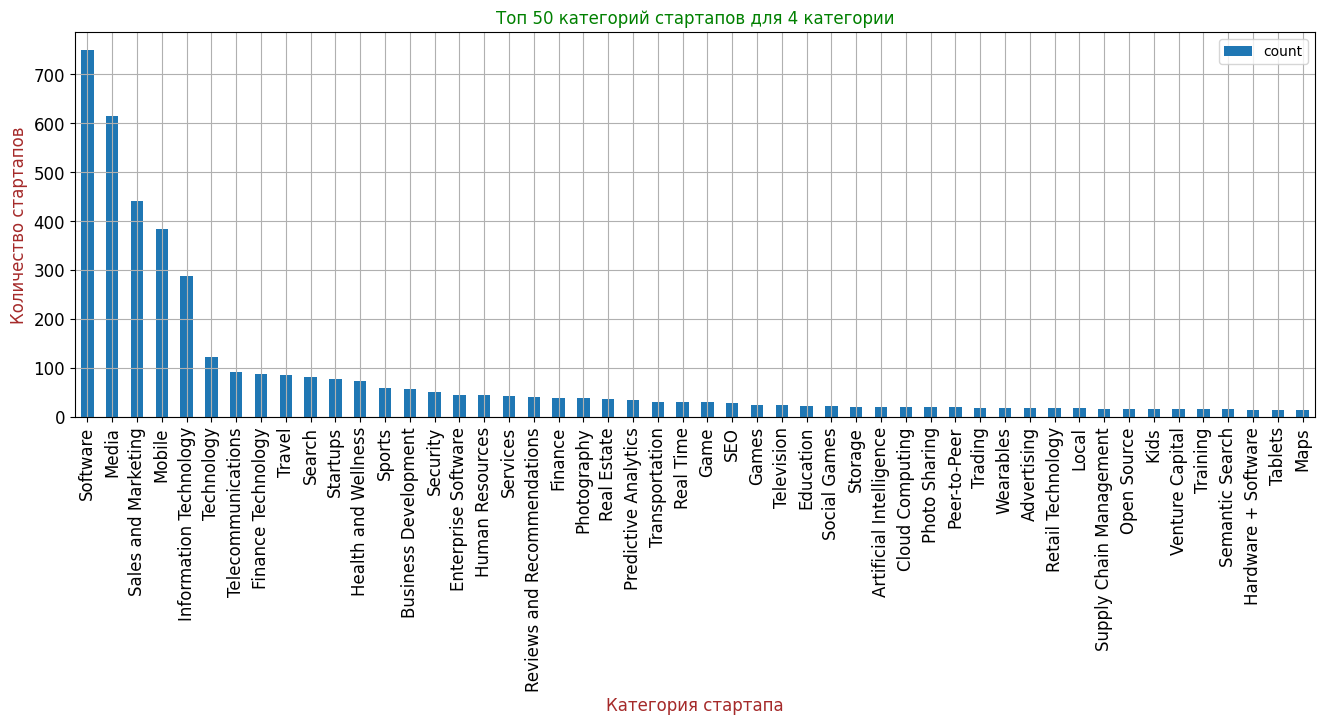

In [64]:
ax =( df_train.query('cat_4 != "Not_used" and cat_4 != "Others"')['cat_4'].value_counts(ascending=False).head(50)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12)
    );

ax.grid()
ax.set_xlabel("Категория стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Количество стартапов",fontsize = 12, color = 'Brown')
ax.set_title("Топ 50 категорий стартапов для 4 категории",fontsize = 12, color = 'Green' );

Как видим распределения категорий для групп категорий похоже друг на друга и напоминают спектр прямоугольного импульса

In [65]:
df_train_top_100 = df_train['cat_0'].value_counts(ascending=False).head(100)
df_unsucc_rate_cat_0 = df_train.query('status =="closed"').pivot_table(index= 'cat_0',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_0',values = 'status',aggfunc=['count'])
df_succ_rate_cat_0 = df_train.query('status =="operating"').pivot_table(index= 'cat_0',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_0',values = 'status',aggfunc=['count'])
df_unsucc_rate_cat_1 = df_train.query('status =="closed"').pivot_table(index= 'cat_1',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_1',values = 'status',aggfunc=['count'])
df_succ_rate_cat_1 = df_train.query('status =="operating"').pivot_table(index= 'cat_1',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_1',values = 'status',aggfunc=['count'])
df_unsucc_rate_cat_2 = df_train.query('status =="closed"').pivot_table(index= 'cat_2',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_2',values = 'status',aggfunc=['count'])
df_succ_rate_cat_2 = df_train.query('status =="operating"').pivot_table(index= 'cat_2',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_2',values = 'status',aggfunc=['count'])
df_unsucc_rate_cat_3 = df_train.query('status =="closed"').pivot_table(index= 'cat_3',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_3',values = 'status',aggfunc=['count'])
df_succ_rate_cat_3 = df_train.query('status =="operating"').pivot_table(index= 'cat_3',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_3',values = 'status',aggfunc=['count'])
df_unsucc_rate_cat_4 = df_train.query('status =="closed"').pivot_table(index= 'cat_4',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_4',values = 'status',aggfunc=['count'])
df_succ_rate_cat_4 = df_train.query('status =="operating"').pivot_table(index= 'cat_4',values = 'status',aggfunc=['count'])*100/df_train.pivot_table(index= 'cat_4',values = 'status',aggfunc=['count'])

df_unsucc_rate_cat_0.columns =['rate']
df_succ_rate_cat_0.columns =['rate']
df_unsucc_rate_cat_1.columns =['rate']
df_succ_rate_cat_1.columns =['rate']
df_unsucc_rate_cat_2.columns =['rate']
df_succ_rate_cat_2.columns =['rate']
df_unsucc_rate_cat_3.columns =['rate']
df_succ_rate_cat_4.columns =['rate']


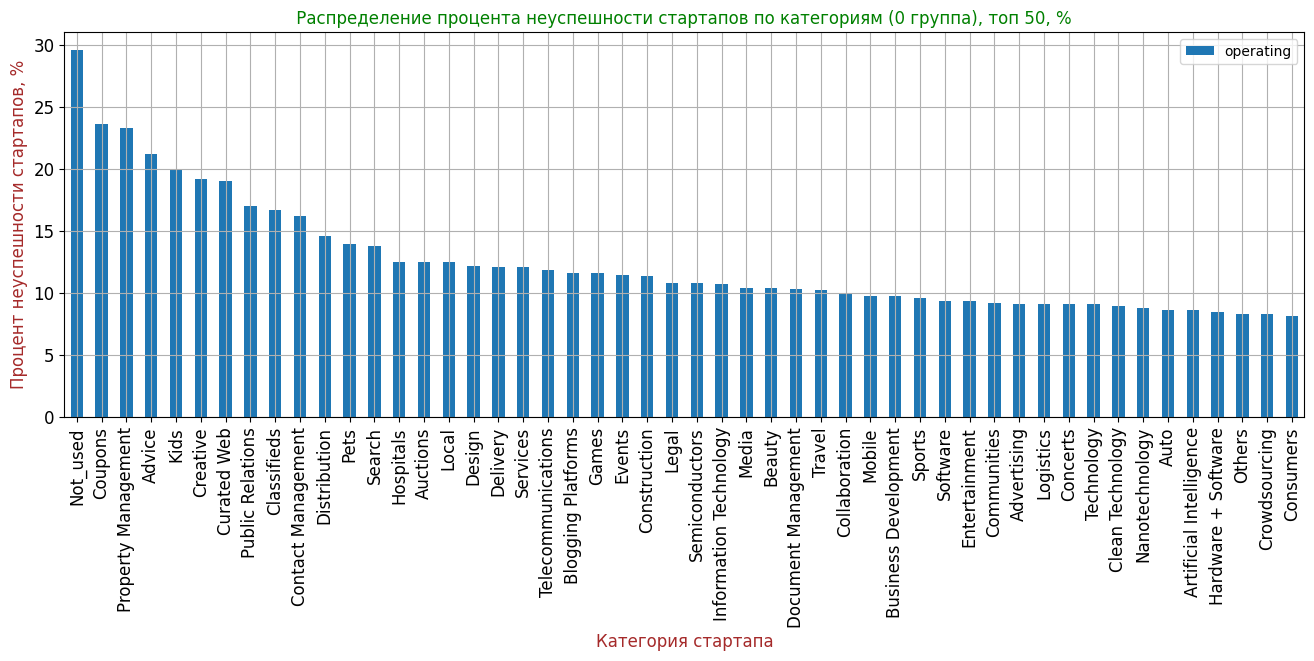

In [66]:
ax =( df_unsucc_rate_cat_0['rate'].sort_values(ascending=False).head(50)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12, label="operating")
    );


ax.grid()
ax.set_xlabel("Категория стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Процент неуспешности стартапов, %",fontsize = 12, color = 'Brown')
ax.set_title(" Распределение процента неуспешности стартапов по категориям (0 группа), топ 50, % ",fontsize = 12, color = 'Green' );

Больше всего неуспешных стартапов в совсем незаполненных категориях стартапов, далее идут купоны и проперти менеджемент, далее консультации и дети для группы 0, также видим что классификация также входит в десятку неуспешных стартапов, опять же все зависит от суммы финансирования, ее менее всего требуется для успешности классификации.

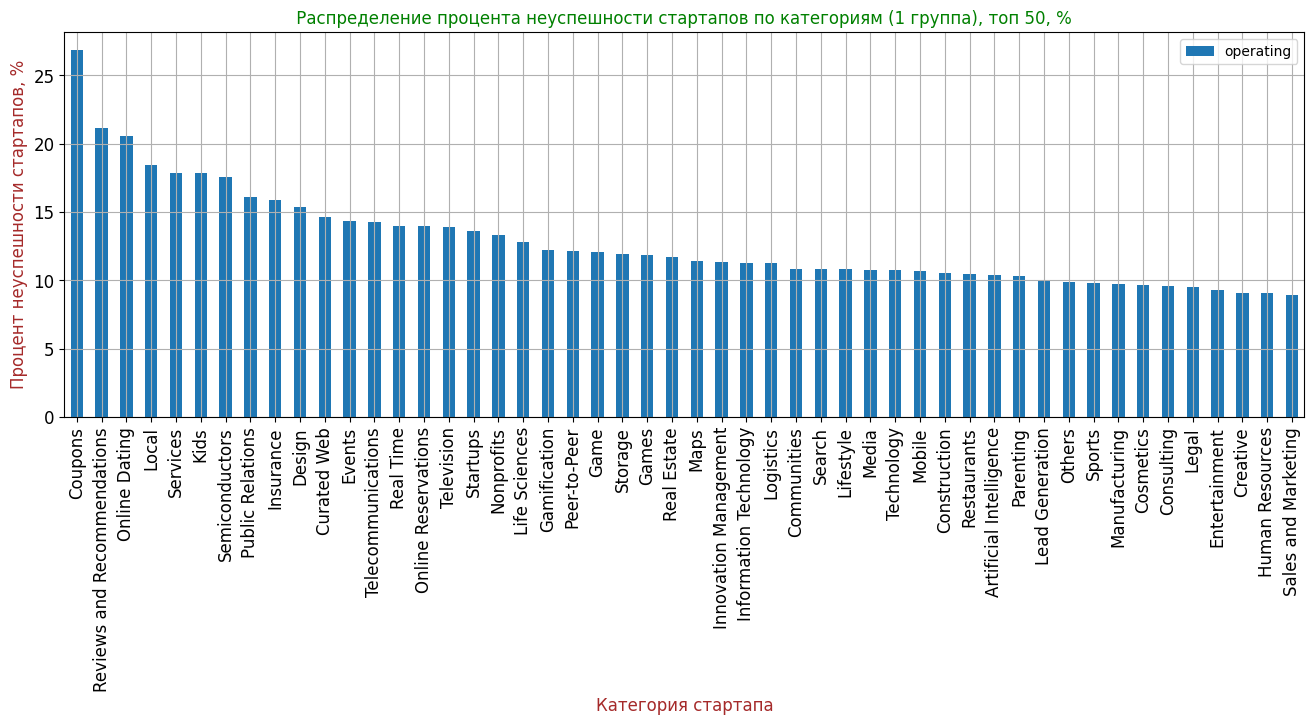

In [67]:
ax =( df_unsucc_rate_cat_1['rate'].sort_values(ascending=False).head(50)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12, label="operating")
    );


ax.grid()
ax.set_xlabel("Категория стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Процент неуспешности стартапов, %",fontsize = 12, color = 'Brown')
ax.set_title(" Распределение процента неуспешности стартапов по категориям (1 группа), топ 50, % ",fontsize = 12, color = 'Green' );

На первом месте по проценту неуспешности лидируют купоны, на втором проверки и рекомендации, на третьем онлайн знакомства 

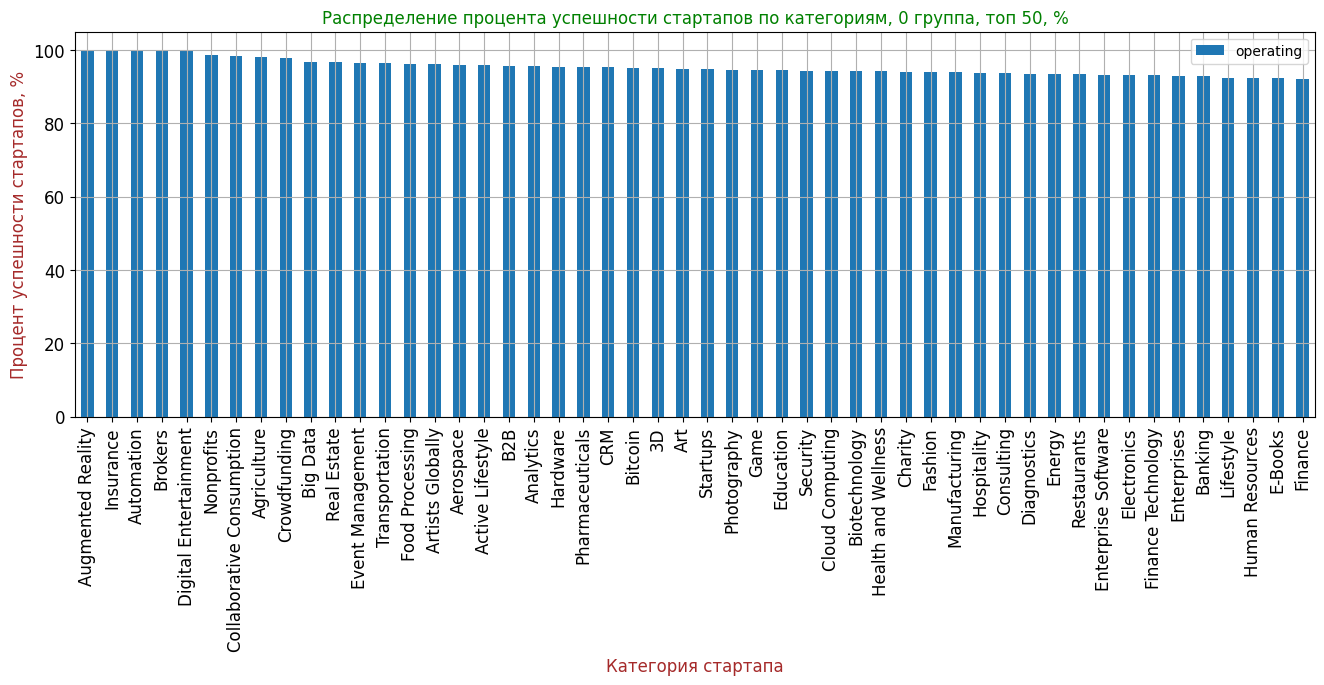

In [68]:
ax =( df_succ_rate_cat_0['rate'].sort_values(ascending=False).head(50)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12, label="operating")
    );


ax.grid()
ax.set_xlabel("Категория стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Процент успешности стартапов, %",fontsize = 12, color = 'Brown')
ax.set_title("Распределение процента успешности стартапов по категориям, 0 группа, топ 50, %",fontsize = 12, color = 'Green' );

По успешности лидируют цифровые развлечения, далее автоматизация и стахование

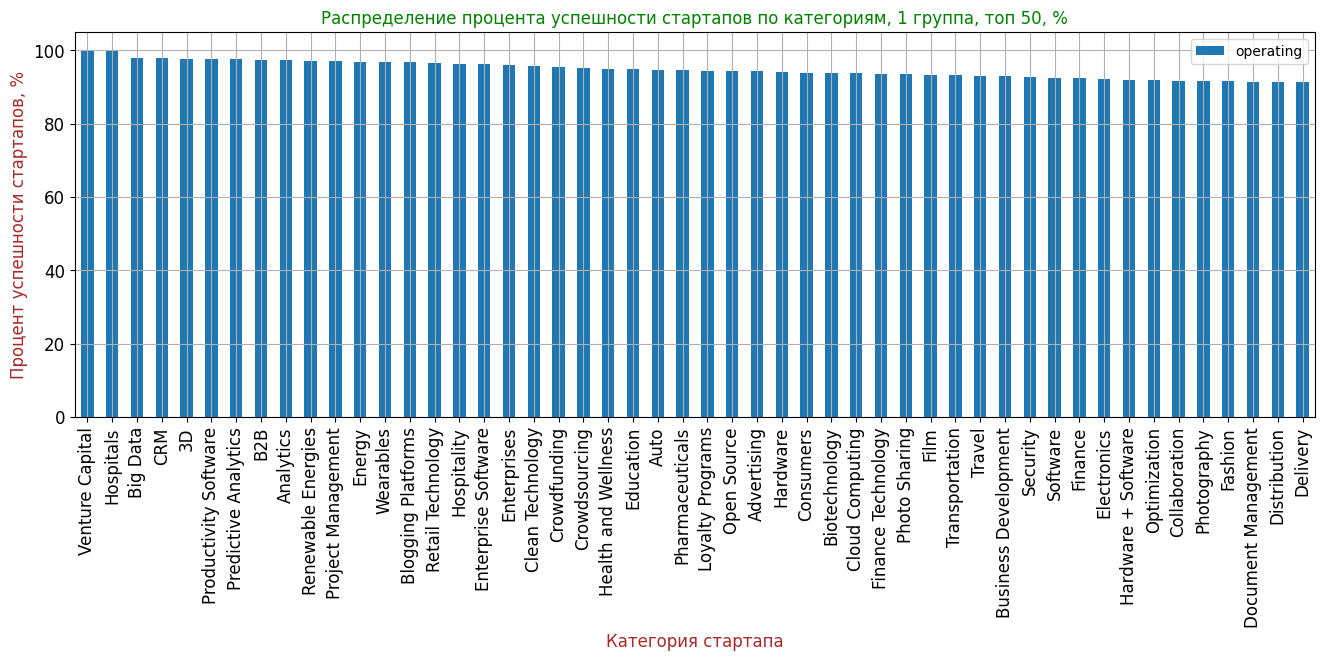

In [69]:
ax =( df_succ_rate_cat_1['rate'].sort_values(ascending=False).head(50)
     .plot(kind = 'bar', figsize = (16,5),rot = 90, legend = True, fontsize = 12, label="operating")
    );


ax.grid()
ax.set_xlabel("Категория стартапа",fontsize = 12, color = 'Brown')
ax.set_ylabel("Процент успешности стартапов, %",fontsize = 12, color = 'Brown')
ax.set_title("Распределение процента успешности стартапов по категориям, 1 группа, топ 50, %",fontsize = 12, color = 'Green' );

Для первой группы  больницы на первом месте, на втором венчурные фонды и на третьем биг дата по проценту успешности стартапов

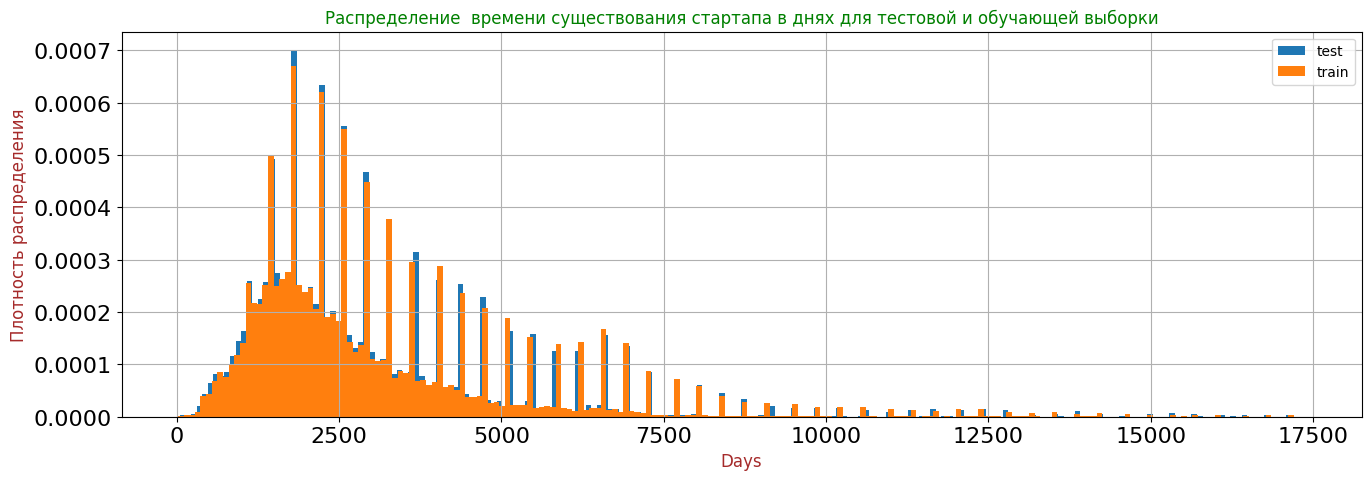

In [70]:
ax =( df_test['lifetime']
     .plot(kind = 'hist', density=True, figsize = (16,5),bins = 200, fontsize = 16, legend = True, label="test")
);
ax =( df_train['lifetime']
     .plot(kind = 'hist', density=True, figsize = (16,5),bins = 200, fontsize = 16, legend = True, label="train")
    );


ax.grid()
ax.set_xlabel("Days",fontsize = 12, color = 'Brown')
ax.set_ylabel("Плотность распределения",fontsize = 12, color = 'Brown')
ax.set_title("Распределение  времени существования стартапа в днях для тестовой и обучающей выборки",fontsize = 12, color = 'Green' );

Видим что распределение для тестовой и обучающей выборки совпадает, что говорит о правильности выбора даты выгрузки данных при расчете lifetime для обучающей выборки 

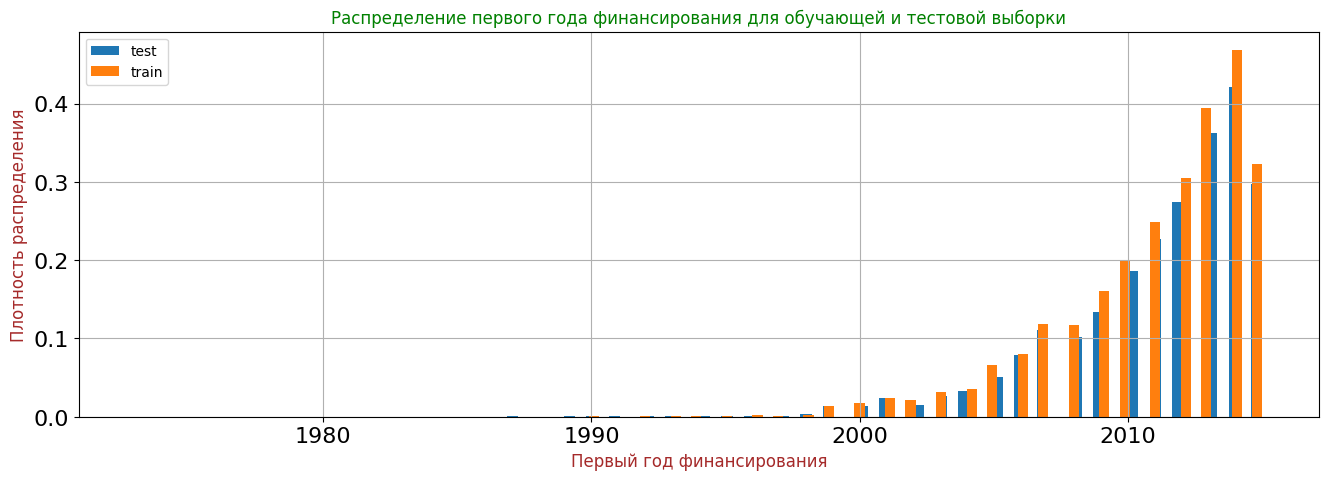

In [71]:
ax =( df_test['first_funding_at_year']
     .plot(kind = 'hist', density=True, figsize = (16,5),bins = 100, fontsize = 16, legend = True, label="test")
);
ax =( df_train['first_funding_at_year']
     .plot(kind = 'hist', density=True, figsize = (16,5),bins = 100, fontsize = 16, legend = True, label="train")
    );


ax.grid()
ax.set_xlabel("Первый год финансирования",fontsize = 12, color = 'Brown')
ax.set_ylabel("Плотность распределения",fontsize = 12, color = 'Brown')
ax.set_title("Распределение первого года финансирования для обучающей и тестовой выборки",fontsize = 12, color = 'Green' );

Видим что распределения совпадают для тестовой и обучающей выборки, что говорит о корректности данных

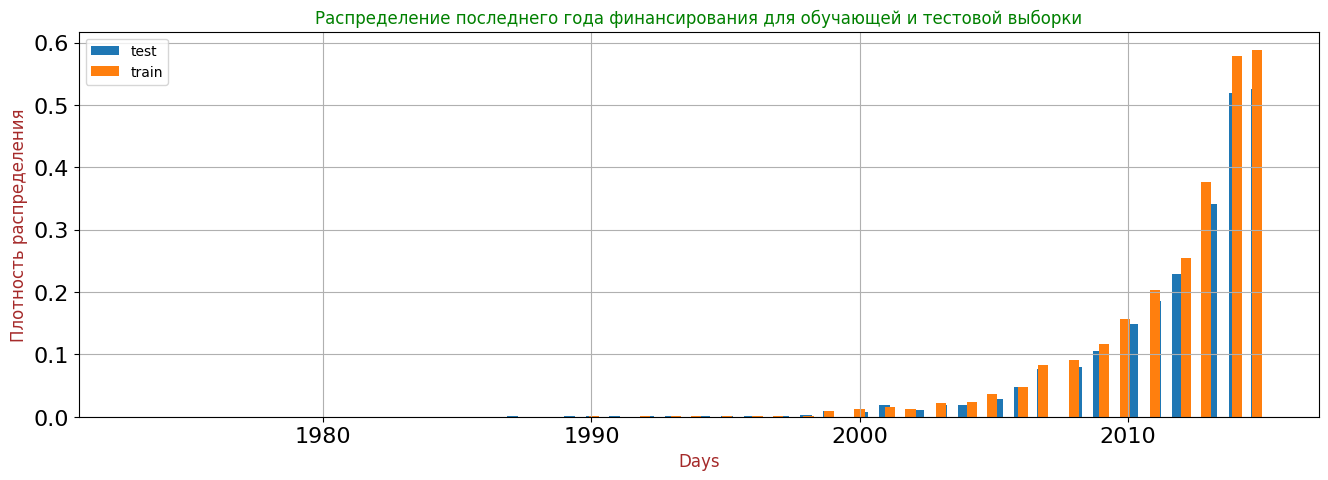

In [72]:
ax =( df_test['last_funding_at_year']
     .plot(kind = 'hist', density=True, figsize = (16,5),bins = 100, fontsize = 16, legend = True, label="test")
);
ax =( df_train['last_funding_at_year']
     .plot(kind = 'hist', density=True, figsize = (16,5),bins = 100, fontsize = 16, legend = True, label="train")
    );


ax.grid()
ax.set_xlabel("Days",fontsize = 12, color = 'Brown')
ax.set_ylabel("Плотность распределения",fontsize = 12, color = 'Brown')
ax.set_title("Распределение последнего года финансирования для обучающей и тестовой выборки",fontsize = 12, color = 'Green' );

Видим что распределения совпадают для тестовой и обучающей выборки, что говорит о корректности данных

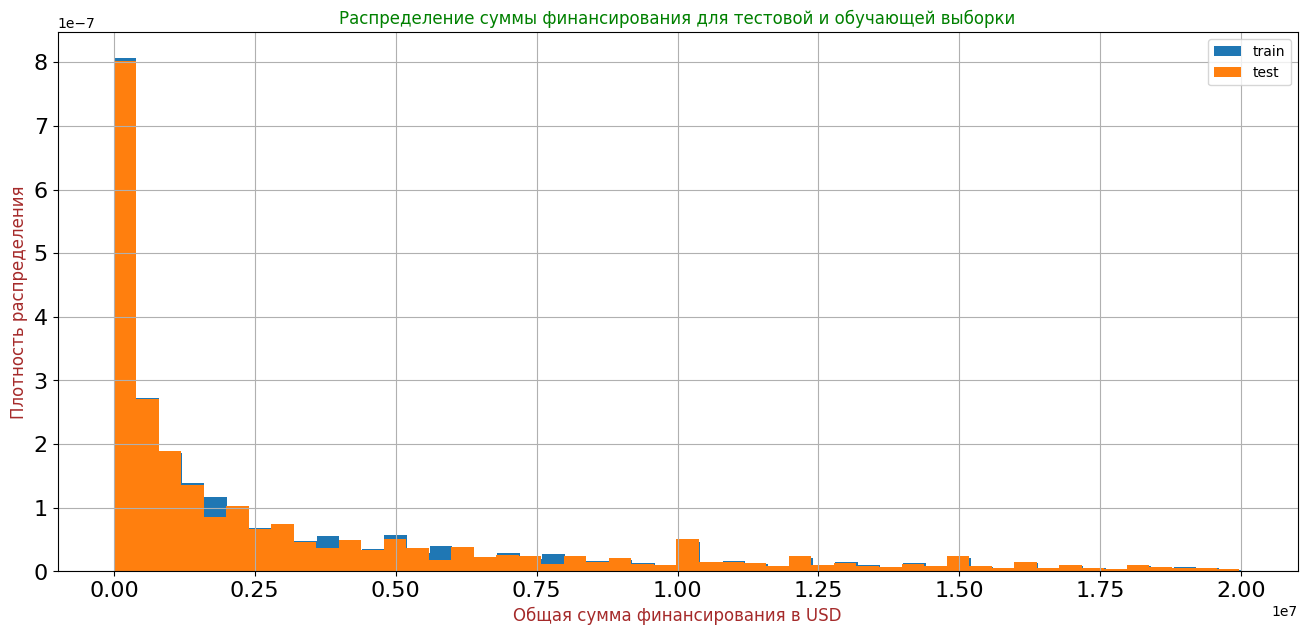

In [73]:
ax =( df_train
     .query('funding_total_usd < 20000000')['funding_total_usd']
     .plot(kind = 'hist', density=True, figsize = (16,7),bins = 50, fontsize = 16, legend = True, label="train")
    );
ax =( df_test
     .query('funding_total_usd < 20000000')['funding_total_usd']
     .plot(kind = 'hist', density=True, figsize = (16,7),bins = 50, fontsize = 16, legend = True, label="test")
);

ax.grid()
ax.set_xlabel("Общая сумма финансирования в USD",fontsize = 12, color = 'Brown')
ax.set_ylabel("Плотность распределения",fontsize = 12, color = 'Brown')
ax.set_title("Распределение суммы финансирования для тестовой и обучающей выборки",fontsize = 12, color = 'Green' );

Видим что распределения совпадают для тестовой и обучающей выборки, что говорит о корректности данных 

Промежуточный вывод
<br/> Данные целевого признака несбалансированы, количество действующих стартапов на порядок выше.
<br/> В обучающих данных есть выбросы с большими суммами финансирования.Распределение по общей сумме финансирования имеет вид убывающей экспоненты, распределение по году основания стартапа имеет вид возрастающей экспоненты с резким падением в 2014г.
<br/> Больше всего финансируют биотехнологии, информационные технологии, програмное обеспечение, продажи и маркетинг и здоровье.
<br/> Большая эффективность финансирования у КЛАССИФИКАЦИИ, Краудфа́ндинга и hardware. В десятку по эффективности также входит big data
<br/> Самыми неэффективными по финансированию являются такие жизненно важные области деятельности как больницы, энергетика, производство, гостепреимство, проперти менеждемент и фармацевтика.
<br/> По странам на первом месте по количеству стартапов с большим отрывом лидируют США, на втором месте Великобритания, на третьем месте Россия, на четвертом Канада и на пятом месте Франция.
<br/> По городам на первом месте лидирует Сан Франциско, на втором Нью Йорк, на третьем Лондон, на четвертом Москва и на пятом Лос Анжелес
<br/> Большинство стартапов было только с одним раундом финансирования  и только один с 19 раундами. Распределение имеет вид убывающей экспоненты.
<br/> Количество стартапов из года в год экспоненциально растет. При этом закрытые стартапы не имеют такого сильного роста. После 2013г наблюдается резкий спад роста стартапов.Также есть волны,примерно раз в 10 лет, предположительно они связаны с финансовыми кризисами.
<br/> Больше всего неуспешных стартапов в совсем незаполненных категориях стартапов, далее идут купоны и проперти менеджемент, далее консультации и дети.
Распределения для тестовой и обучающей выборки совпадает, что говорит о корректности подготовленных данных


## Корреляционный анализ данных

In [74]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   funding_total_usd      42447 non-null  Int64         
 1   status                 52516 non-null  object        
 2   country_code           52516 non-null  object        
 3   state_code             52516 non-null  object        
 4   region                 52516 non-null  object        
 5   city                   52516 non-null  object        
 6   funding_rounds         52516 non-null  int64         
 7   founded_at             52516 non-null  datetime64[ns]
 8   first_funding_at       52516 non-null  datetime64[ns]
 9   last_funding_at        52516 non-null  datetime64[ns]
 10  closed_at              4917 non-null   datetime64[ns]
 11  cat_0                  52516 non-null  object        
 12  cat_1                  52516 non-null  object       

In [75]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   funding_total_usd      10547 non-null  Int64         
 1   country_code           13125 non-null  object        
 2   state_code             13125 non-null  object        
 3   region                 13125 non-null  object        
 4   city                   13125 non-null  object        
 5   funding_rounds         13125 non-null  int64         
 6   first_funding_at       13125 non-null  datetime64[ns]
 7   last_funding_at        13125 non-null  datetime64[ns]
 8   lifetime               13125 non-null  int64         
 9   cat_0                  13125 non-null  object        
 10  cat_1                  13125 non-null  object        
 11  cat_2                  13125 non-null  object        
 12  cat_3                  13125 non-null  object     

In [76]:

df_train['first_funding_at'] = df_train['first_funding_at'].apply(lambda x: pd.to_datetime(x).value )
df_train['last_funding_at'] = df_train['last_funding_at'].apply(lambda x: pd.to_datetime(x).value )
df_test['first_funding_at'] = df_test['first_funding_at'].apply(lambda x: pd.to_datetime(x).value )
df_test['last_funding_at'] = df_test['last_funding_at'].apply(lambda x: pd.to_datetime(x).value )
df_train['funding_frieq'] = (df_train['last_funding_at'] - df_train['first_funding_at'])/ df_train['funding_rounds']
df_test['funding_frieq'] = (df_test['last_funding_at'] - df_test['first_funding_at'])/ df_test['funding_rounds']
df_train_clear = df_train[['funding_total_usd',
                           'funding_rounds',
                           'first_funding_at',
                           'funding_frieq',
#                           'last_funding_at',
                           'lifetime',
                           'status',
#                           'country_code',
#                           'state_code',
#                           'region',
                           'city',
                           'cat_0',
                           'cat_1',
                           'cat_2',
                           'cat_3',
                           'cat_4',
#                          'cat_5',
#                          'cat_6',
#                           'cat_7',
#                           'cat_8'
                          ]]

df_test_clear = df_test[['funding_total_usd',
                           'funding_rounds',
                           'first_funding_at',
                           'funding_frieq',
#                           'last_funding_at',
                           'lifetime',
#                           'country_code',
#                           'state_code',
#                           'region',
                           'city',
                           'cat_0',
                           'cat_1',
                           'cat_2',
                           'cat_3',
                           'cat_4',
#                           'cat_5',
#                           'cat_6',
#                           'cat_7',
#                           'cat_8'
                        ]]
                         

In [77]:
df_train_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funding_total_usd  42447 non-null  Int64  
 1   funding_rounds     52516 non-null  int64  
 2   first_funding_at   52516 non-null  int64  
 3   funding_frieq      52516 non-null  float64
 4   lifetime           52516 non-null  int64  
 5   status             52516 non-null  object 
 6   city               52516 non-null  object 
 7   cat_0              52516 non-null  object 
 8   cat_1              52516 non-null  object 
 9   cat_2              52516 non-null  object 
 10  cat_3              52516 non-null  object 
 11  cat_4              52516 non-null  object 
dtypes: Int64(1), float64(1), int64(3), object(7)
memory usage: 7.3+ MB


In [78]:
inter_cols = ['funding_total_usd','lifetime','first_funding_at','funding_frieq']
matrix = df_train_clear.phik_matrix(interval_cols=inter_cols)
matrix

/home/anton/myenv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable city is large: 4478. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(


funding_total_usd  funding_rounds  first_funding_at  \
funding_total_usd           1.000000        0.323651          0.098080   
funding_rounds              0.323651        1.000000          0.236855   
first_funding_at            0.098080        0.236855          1.000000   
funding_frieq               0.000000        0.374754          0.534087   
lifetime                    0.116706        0.227559          0.670201   
status                      0.000000        0.100557          0.180430   
city                        0.000000        0.000000          0.392455   
cat_0                       0.068941        0.219865          0.325619   
cat_1                       0.050609        0.142539          0.159441   
cat_2                       0.181195        0.070546          0.197843   
cat_3                       0.120090        0.125761          0.114341   
cat_4                       0.182965        0.180605          0.000000   

                   funding_frieq  lifetime    status      city     cat_0  \
funding_total_usd       0.000000  0.116706  0.000000  0.000000  0.068941   
funding_rounds          0.374754  0.227559  0.100557  0.000000  0.219865   
first_funding_at        0.534087  0.670201  0.180430  0.392455  0.325619   
funding_frieq           1.000000  0.324838  0.058038  0.000000  0.174698   
lifetime                0.324838  1.000000  0.534846  0.647552  0.321536   
status                  0.058038  0.534846  1.000000  0.135046  0.224187   
city                    0.000000  0.647552  0.135046  1.000000  0.498237   
cat_0                   0.174698  0.321536  0.224187  0.498237  1.000000   
cat_1                   0.000000  0.181333  0.091257  0.000000  0.819184   
cat_2                   0.000000  0.182255  0.084734  0.000000  0.659974   
cat_3                   0.000000  0.106466  0.054180  0.000000  0.561322   
cat_4                   0.000000  0.047048  0.031878  0.000000  0.436819   

                      cat_1     cat_2     cat_3     cat_4  
funding_total_usd  0.050609  0.181195  0.120090  0.182965  
funding_rounds     0.142539  0.070546  0.125761  0.180605  
first_funding_at   0.159441  0.197843  0.114341  0.000000  
funding_frieq      0.000000  0.000000  0.000000  0.000000  
lifetime           0.181333  0.182255  0.106466  0.047048  
status             0.091257  0.084734  0.054180  0.031878  
city               0.000000  0.000000  0.000000  0.000000  
cat_0              0.819184  0.659974  0.561322  0.436819  
cat_1              1.000000  0.866069  0.623763  0.555409  
cat_2              0.866069  1.000000  0.757181  0.612784  
cat_3              0.623763  0.757181  1.000000  0.842355  
cat_4              0.555409  0.612784  0.842355  1.000000

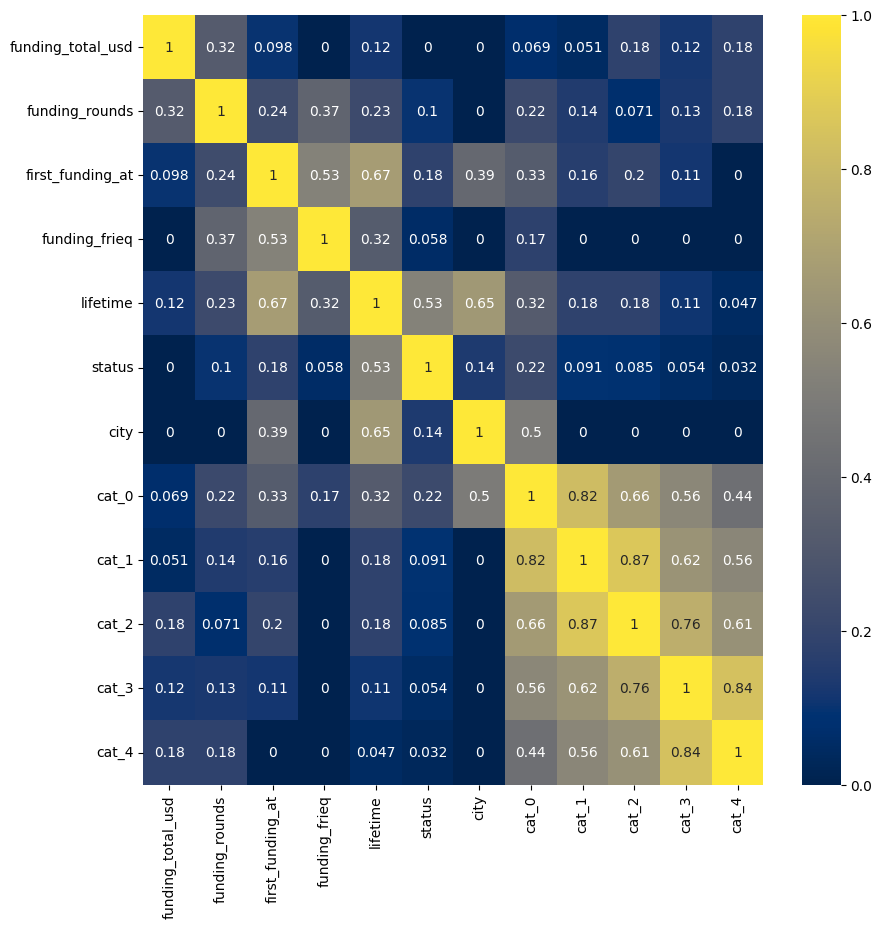

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cmap='cividis');

In [80]:
matrix_test = df_test_clear.phik_matrix(interval_cols=inter_cols)
matrix_test

/home/anton/myenv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable city is large: 2118. Are you sure this is not an interval variable? Analysis for pairs of variables including city can be slow.
  warnings.warn(


funding_total_usd  funding_rounds  first_funding_at  \
funding_total_usd           1.000000        0.409371          0.000000   
funding_rounds              0.409371        1.000000          0.213144   
first_funding_at            0.000000        0.213144          1.000000   
funding_frieq               0.000000        0.561636          0.400241   
lifetime                    0.279935        0.229152          0.662554   
city                        0.000000        0.000000          0.495026   
cat_0                       0.000000        0.157245          0.278121   
cat_1                       0.000000        0.065301          0.000000   
cat_2                       0.174326        0.000000          0.000000   
cat_3                       0.234371        0.282967          0.000000   
cat_4                       0.000000        0.166039          0.000000   

                   funding_frieq  lifetime      city     cat_0     cat_1  \
funding_total_usd       0.000000  0.279935  0.000000  0.000000  0.000000   
funding_rounds          0.561636  0.229152  0.000000  0.157245  0.065301   
first_funding_at        0.400241  0.662554  0.495026  0.278121  0.000000   
funding_frieq           1.000000  0.394418  0.000000  0.248056  0.214098   
lifetime                0.394418  1.000000  0.758640  0.313633  0.092267   
city                    0.000000  0.758640  1.000000  0.464024  0.000000   
cat_0                   0.248056  0.313633  0.464024  1.000000  0.814230   
cat_1                   0.214098  0.092267  0.000000  0.814230  1.000000   
cat_2                   0.280027  0.137262  0.000000  0.683021  0.880328   
cat_3                   0.146606  0.000000  0.000000  0.624896  0.695006   
cat_4                   0.300758  0.000000  0.000000  0.573279  0.686091   

                      cat_2     cat_3     cat_4  
funding_total_usd  0.174326  0.234371  0.000000  
funding_rounds     0.000000  0.282967  0.166039  
first_funding_at   0.000000  0.000000  0.000000  
funding_frieq      0.280027  0.146606  0.300758  
lifetime           0.137262  0.000000  0.000000  
city               0.000000  0.000000  0.000000  
cat_0              0.683021  0.624896  0.573279  
cat_1              0.880328  0.695006  0.686091  
cat_2              1.000000  0.810278  0.769868  
cat_3              0.810278  1.000000  0.852575  
cat_4              0.769868  0.852575  1.000000

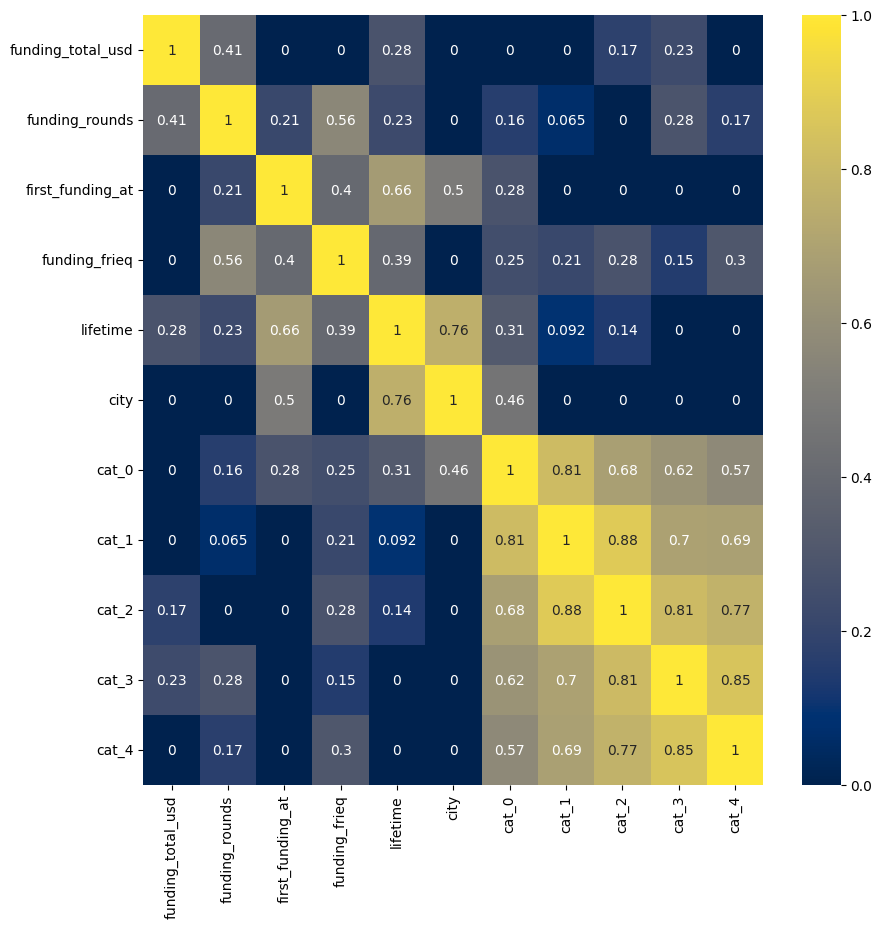

In [81]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix_test, annot=True, cmap='cividis');

Видим что высокий процент корреляции имеют признаки first_funding_at и last_funding_at, это легко обьясняется тем что в основном количество раундов финансирования равно одному и в этом случае first_funding_at = last_funding_at, но убрать мы один из этих признаков просто так не можем по причине их важности для модели прогнозирования успешности стартапа, что подтверждает анализ признаков и логическое видение, что для прогноза успешности может потребоваться частота раундов финансирования, в связи с чем введем новый признак - частота раундов финансирования и удалим last_funding_at. Из признаков удалили коды стран, коды штатов и регионы так как они имеют между собой и городом стартапа прямую зависимость(мультиколлениарность), также удалили категориальные группы с 5 по 11, ввиду их сильной зависимостью между собой и с остальными группами.
По итогу корректировки признаков избавились от мультиколлениарности

## Обучение модели

In [82]:
RANDOM_STATE = 42

In [83]:
df_test_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funding_total_usd  10547 non-null  Int64  
 1   funding_rounds     13125 non-null  int64  
 2   first_funding_at   13125 non-null  int64  
 3   funding_frieq      13125 non-null  float64
 4   lifetime           13125 non-null  int64  
 5   city               13125 non-null  object 
 6   cat_0              13125 non-null  object 
 7   cat_1              13125 non-null  object 
 8   cat_2              13125 non-null  object 
 9   cat_3              13125 non-null  object 
 10  cat_4              13125 non-null  object 
dtypes: Int64(1), float64(1), int64(3), object(6)
memory usage: 1.7+ MB


In [84]:
X_train_f = df_train_clear.drop('status', axis =1)
y_train_f =df_train_clear['status']

In [85]:
X_test = df_test_clear

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X_train_f, y_train_f, test_size = 0.2, stratify = y_train_f)

Ввиду наличия в обучающих и тестовых данных огромного числа категорий выбрали модель Catboost, которая позволяет работать с большим числом категорий без предварительной их обработки. 

In [87]:

cat_features = [5,6,7,8,9,10]
y_train

name
Drop Development             operating
EnvironmentIQ                operating
Burger Singh                 operating
SmatFone™                    operating
Cutwater Asset Management    operating
                               ...    
SponsorHub                   operating
Aurinia Pharmaceuticals         closed
GMZ Energy                   operating
Cyvera                       operating
Nanameue                     operating
Name: status, Length: 42012, dtype: object

Ввиду несбаласированности целевого признака и важности предсказания закрытия стартапа, примем за положительный результат нахождение меньшего из классов, то есть обозначим за 1 закрытие стартапа. 

In [88]:

y_train = y_train.apply(lambda x: 0 if x == 'operating' else 1)
y_val = y_val.apply(lambda x: 0 if x == 'operating' else 1)
y_train.head()

name
Drop Development             0
EnvironmentIQ                0
Burger Singh                 0
SmatFone™                    0
Cutwater Asset Management    0
Name: status, dtype: int64

In [89]:
y_val.head()

name
IntY                  0
Surance               0
Qualiall              0
Clearsight Systems    0
SiTime                0
Name: status, dtype: int64

In [90]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42012 entries, Drop Development to Nanameue
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funding_total_usd  33980 non-null  Int64  
 1   funding_rounds     42012 non-null  int64  
 2   first_funding_at   42012 non-null  int64  
 3   funding_frieq      42012 non-null  float64
 4   lifetime           42012 non-null  int64  
 5   city               42012 non-null  object 
 6   cat_0              42012 non-null  object 
 7   cat_1              42012 non-null  object 
 8   cat_2              42012 non-null  object 
 9   cat_3              42012 non-null  object 
 10  cat_4              42012 non-null  object 
dtypes: Int64(1), float64(1), int64(3), object(6)
memory usage: 3.9+ MB


In [91]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funding_total_usd  10547 non-null  Int64  
 1   funding_rounds     13125 non-null  int64  
 2   first_funding_at   13125 non-null  int64  
 3   funding_frieq      13125 non-null  float64
 4   lifetime           13125 non-null  int64  
 5   city               13125 non-null  object 
 6   cat_0              13125 non-null  object 
 7   cat_1              13125 non-null  object 
 8   cat_2              13125 non-null  object 
 9   cat_3              13125 non-null  object 
 10  cat_4              13125 non-null  object 
dtypes: Int64(1), float64(1), int64(3), object(6)
memory usage: 1.7+ MB


In [92]:
scorer = make_scorer(f1_score, pos_label= 1)

In [93]:
num_columns = ['funding_total_usd', 'funding_rounds','first_funding_at','funding_frieq','lifetime']

In [94]:

params = dict(
    loss_function='Logloss',
    iterations=1000, 
    learning_rate=0.19,
    depth=5,
    l2_leaf_reg=6.3,  
    random_seed=42, 
    eval_metric = 'F1',
    auto_class_weights = 'SqrtBalanced',
)
pipe_num = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])
  

preprocessor = ColumnTransformer(
    transformers=[
       ( 'num', pipe_num, num_columns )
    ], remainder='passthrough')


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(**params))
])
  

In [95]:
   
X_train_p = pd.DataFrame(
    pipeline.named_steps['preprocessor'].fit_transform(X_train),
    columns= pipeline.named_steps['preprocessor'].get_feature_names_out())
 
X_test_p = pd.DataFrame(
    pipeline.named_steps['preprocessor'].transform(X_val),
    columns= pipeline.named_steps['preprocessor'].get_feature_names_out())


In [96]:

pipeline.fit(X_train, y_train, classifier__cat_features=cat_features, classifier__eval_set = [(X_test_p, y_val)], classifier__verbose=False, classifier__plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

/home/anton/myenv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['funding_total_usd',
                                                   'funding_rounds',
                                                   'first_funding_at',
                                                   'funding_frieq',
                                                   'lifetime'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x771eac4717c0>)])

In [97]:
params = dict(
    loss_function='Logloss',
    iterations=1000, 
    learning_rate=0.19,
    depth=5,
    l2_leaf_reg=6.3,  
    random_seed=42, 
    eval_metric = 'F1', 
#    scale_pos_weight = 0.45,
    auto_class_weights = 'SqrtBalanced',
#    subsample = 0.97, 
#    min_child_samples = 8 
)
cv_data = cv(
    params=params,
    pool=Pool(X_train_f, label=y_train_f.apply(lambda x: 0 if x == 'operating' else 1), cat_features=cat_features),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=True, # Никуда без визуализатора
    stratified=True, 
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9128309664
bestIteration = 698

Training on fold [1/5]

bestTest = 0.907853797
bestIteration = 825

Training on fold [2/5]

bestTest = 0.8994086656
bestIteration = 419

Training on fold [3/5]

bestTest = 0.9081860547
bestIteration = 316

Training on fold [4/5]

bestTest = 0.9129228176
bestIteration = 559



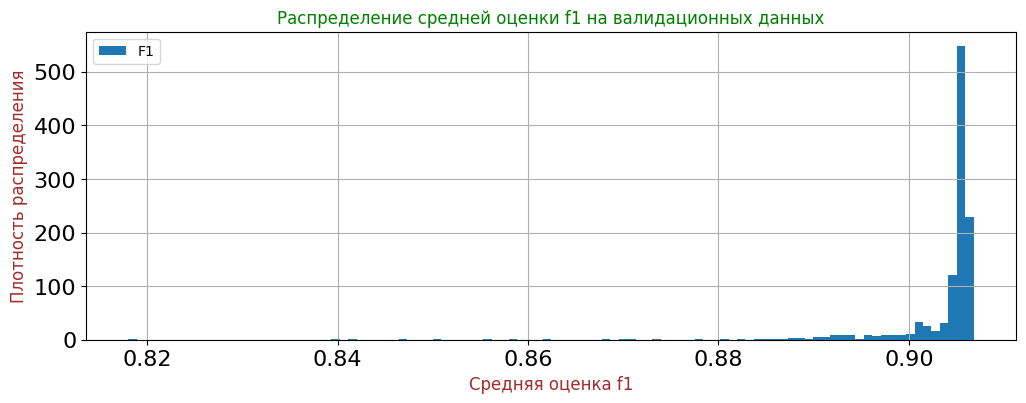

In [98]:
ax =( cv_data['test-F1-mean']
     .plot(kind = 'hist', density=True, figsize = (12,4),bins = 100, fontsize = 16, legend = True, label="F1")
);
ax.grid()
ax.set_xlabel("Средняя оценка f1",fontsize = 12, color = 'Brown')
ax.set_ylabel("Плотность распределения",fontsize = 12, color = 'Brown')
ax.set_title("Распределение средней оценки f1 на валидационных данных",fontsize = 12, color = 'Green' );

In [99]:
cv_data.mean()

iterations            499.500000
test-F1-mean            0.903521
test-F1-std             0.005647
train-F1-mean           0.940171
train-F1-std            0.001617
test-Logloss-mean       0.139147
test-Logloss-std        0.004502
train-Logloss-mean      0.084570
train-Logloss-std       0.001343
dtype: float64

In [100]:
cv_data.describe()

iterations  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  \
count  1000.000000   1000.000000  1000.000000    1000.000000   1000.000000   
mean    499.500000      0.903521     0.005647       0.940171      0.001617   
std     288.819436      0.006929     0.001065       0.023784      0.000850   
min       0.000000      0.818011     0.003955       0.819558      0.000259   
25%     249.750000      0.904777     0.005075       0.924738      0.001289   
50%     499.500000      0.905439     0.005573       0.944781      0.001469   
75%     749.250000      0.905819     0.006086       0.959870      0.001898   
max     999.000000      0.906811     0.020511       0.970559      0.014684   

       test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
count        1000.000000       1000.000000         1000.000000   
mean            0.139147          0.004502            0.084570   
std             0.017374          0.000787            0.035306   
min             0.133797          0.003039            0.048652   
25%             0.134437          0.003951            0.059760   
50%             0.135802          0.004596            0.075346   
75%             0.137725          0.004808            0.099957   
max             0.484682          0.010996            0.484535   

       train-Logloss-std  
count        1000.000000  
mean            0.001343  
std             0.000436  
min             0.000326  
25%             0.001043  
50%             0.001345  
75%             0.001537  
max             0.008008

In [101]:
preds = pipeline.predict(X_val)
F1 = f1_score(y_val, preds, pos_label= 1)
F1

0.8850754030161206

In [102]:
pipeline.named_steps['classifier'].tree_count_

423

In [103]:
# импорт класса дамми-модели 
# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_preds = dummy_model.predict(X_val)

# оценка качества модели по метрике accuracy
dummy_F1 = f1_score(y_val, dummy_model_preds, pos_label= 1)
dummy_F1 

0.0

In [104]:
parameters = {'classifier__learning_rate': distributions.FloatDistribution(0.15, 0.2),
              'classifier__l2_leaf_reg': distributions.FloatDistribution(1.5, 10),
              'classifier__depth': distributions.IntDistribution(5,6),
             }

oscv = OptunaSearchCV(pipeline,
                      parameters,
                      scoring=scorer,
                      cv=5,
                      n_trials=100,
                      random_state=RANDOM_STATE
                     )


#oscv.fit(X_train, y_train, classifier__cat_features= cat_features, classifier__eval_set = [(X_test_p, y_val)],  classifier__verbose = 50, classifier__early_stopping_rounds = 200)


/tmp/ipykernel_1787345/2172115792.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  oscv = OptunaSearchCV(pipeline,


In [105]:
#oscv.best_params_

In [106]:
#oscv.best_score_

## Анализ важности признаков

Посмотрим на важность признаков

In [107]:
coef = pipeline.named_steps['classifier'].get_feature_importance(prettified=True)
coef['Feature Id'] = coef['Feature Id'].astype('int64')
coef = coef.set_index('Feature Id').sort_index()
feature_importance = pd.DataFrame({'Feature': X_train_p.columns, 'Importance': coef['Importances']})


/tmp/ipykernel_1787345/3297875987.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(feature_importance['Feature'], fontsize=15 )


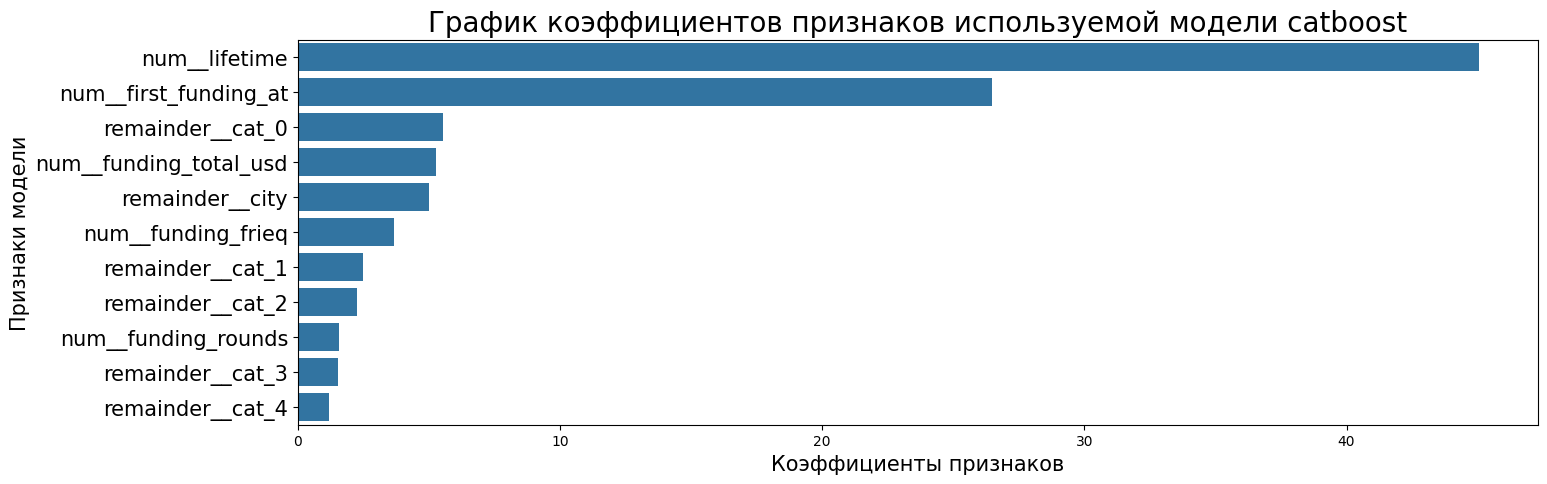

In [108]:

feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(16, 5))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance)
ax.set_title('График коэффициентов признаков используемой модели catboost', fontsize=20)
ax.set_xlabel('Коэффициенты признаков', fontsize=15)
ax.set_ylabel('Признаки модели', fontsize=15)
ax.set_yticklabels(feature_importance['Feature'], fontsize=15 )
plt.show()

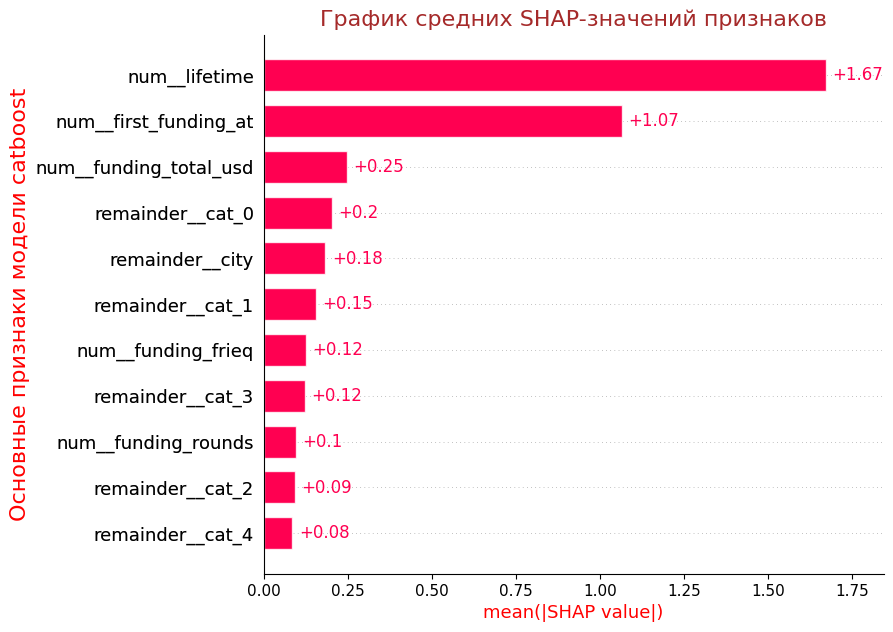

In [109]:
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer(X_test_p, y_train)
#shap.plots.bar(shap_values[:,:,1], max_display=19)
plt.ylabel('Основные признаки модели catboost', color='red', fontsize=16);
plt.xlabel('Средние SHAP-значения признаков', color='red', fontsize=16);
plt.title('График средних SHAP-значений признаков', color='brown', fontsize=16);
shap.plots.bar(shap_values, max_display=19)


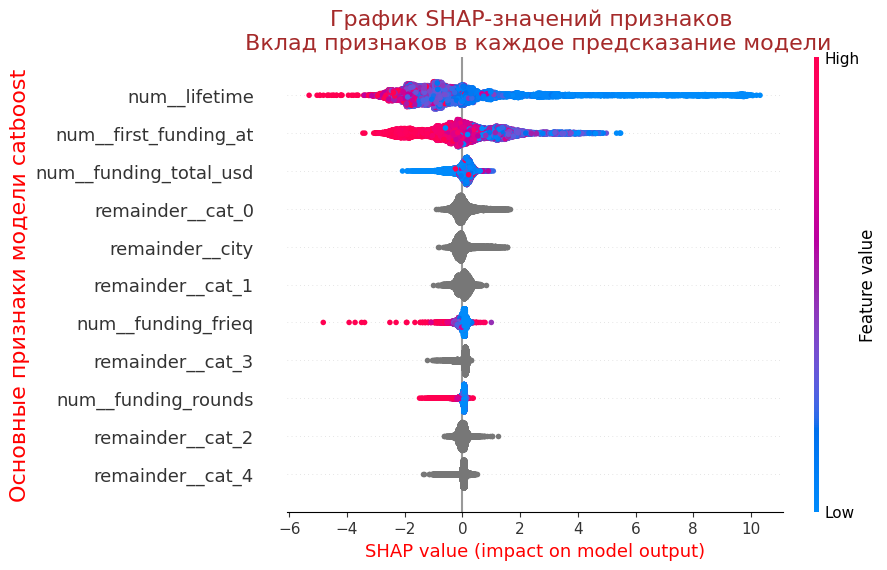

In [110]:

plt.ylabel('Основные признаки модели catboost', color='red', fontsize=16);
plt.xlabel('SHAP-значения признаков', color='red', fontsize=16);
plt.title('График SHAP-значений признаков \n Вклад признаков в каждое предсказание модели', color='brown', fontsize=16);
shap.plots.beeswarm(shap_values, max_display=19)

На первом месте признак -время существования стартапа в днях, на втором месте - дата первого раунда финансирования, на третьем месте - общая сумма финансирования стартапа, на четвертом месте город стартапа и на пятом месте нулевая группа категории.
Все оставшиеся после корректировки в корреляционном анализе признаки вносят существенный вклад в точность модели прогнозирования успешности стартапов и не требуют удаления.

In [111]:
df_test['status'] = pipeline.predict(X_test)

In [112]:
y_pred = df_test[['status']]

In [113]:
#y_pred_fin = label_encoder.inverse_transform(y_pred)
y_pred['status'] = y_pred['status'].apply(lambda x:'operating' if x == 0 else 'closed')

y_pred['status'].value_counts()

/tmp/ipykernel_1787345/702088457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_pred['status'] = y_pred['status'].apply(lambda x:'operating' if x == 0 else 'closed')


status
operating    11908
closed        1217
Name: count, dtype: int64

In [114]:
y_pred

status
name                             
Crystalsol              operating
JBI Fish & Wings        operating
COINPLUS                operating
Imagine Communications  operating
DNA13                   operating
...                           ...
Jymob                   operating
GlobaTrek               operating
Inkd.com                operating
AdWill                  operating
RingCentral             operating

[13125 rows x 1 columns]

In [115]:
y_pred.to_csv('kaggle_startups_submit_28112024_v83.csv')

Общий вывод 
<br/> В данных присутствует большое количество категориальных признаков, оптимальная обработка которых представляет довольно сложную и нетревиальную задачу. Для оптимальной обработки большого количества категориальных признаков, их укрупнения могут потребоваться алгоритмы обработки естественного языка. К сожалению ни ChatGPT ни ЯндексGPT не помогли в данном вопросе, возможно не хватило знаний по использованию нейросетей. Была проведена работа по разбиению категориальных признаков на группы по их очередности в строках, также было произведено ручное укрупнение категориальных признаков. Была проведена работа по добавлению нового признака lifetime в обучающую выборку, путем проверки времени последнего закрытия стартапа, а также подгонки гистограммы обучающей выборки под тестовую для признака lifetime. 
<br/> Данные целевого признака несбалансированы, количество действующих стартапов на порядок выше.
<br/> В обучающих данных есть выбросы с большими суммами финансирования.Распределение по общей сумме финансирования имеет вид убывающей экспоненты, распределение по году основания стартапа имеет вид возрастающей экспоненты с резким падением в 2014г.
<br/> Больше всего финансируют биотехнологии, информационные технологии, програмное обеспечение, продажи и маркетинг и здоровье.
<br/> Большая эффективность финансирования у КЛАССИФИКАЦИИ, Краудфа́ндинга и hardware по сохранению инвестиций. В десятку по эффективности также входит big data
<br/> Самыми неэффективными по финансированию являются такие жизненно важные области деятельности как больницы, энергетика, производство, гостепреимство, проперти менеждемент и фармацевтика.
<br/> По странам на первом месте по количеству стартапов с большим отрывом лидируют США, на втором месте Великобритания, на третьем месте Россия, на четвертом Канада и на пятом месте Франция.
<br/> По городам на первом месте лидирует Сан Франциско, на втором Нью Йорк, на третьем Лондон, на четвертом Москва и на пятом Лос Анжелес
<br/> Большинство стартапов было только с одним раундом финансирования  и только один с 19 раундами. Распределение имеет вид убывающей экспоненты.
<br/> Количество стартапов из года в год экспоненциально растет. При этом закрытые стартапы не имеют такого сильного роста. После 2013г наблюдается резкий спад роста стартапов.Также есть волны,примерно раз в 10 лет, предположительно они связаны с финансовыми кризисами.
<br/> Больше всего неуспешных стартапов в совсем незаполненных категориях стартапов, далее идут купоны и проперти менеджемент, далее консультации и дети.
Гистограммы для тестовой и обучающей выборки совпадает, что говорит о корректности подготовленных данных.
<br/> Высокий процент корреляции имеют признаки first_funding_at и last_funding_at, это легко обьясняется тем что в основном количество раундов финансирования равно одному и в этом случае first_funding_at = last_funding_at, в связи с чем ввели новый признак - частота раундов финансирования и удалили last_funding_at из модели. Из признаков удалили коды стран, коды штатов и регионы так как они имеют между собой и городом стартапа прямую зависимость(мультиколлениарность), также удалили категориальные группы с 5 по 11, ввиду их сильной зависимостью между собой и с остальными группами.
<br/> По итогу корректировки признаков избавились от мультиколлениарности, что подтверждает матрица корреляции.
<br/> Ввиду наличия в обучающих и тестовых данных огромного числа категорий, выбрали модель Catboost, которая позволяет работать с большим числом категорий без из предварительной их обработки. После проведения поиска оптимальных гиперпараметров с помощью OptunaSearchCV остановились на следующих параметрах CatBoost - learning_rate=0.19, depth=5, l2_leaf_reg=6.3, random_seed=42, eval_metric = 'F1', auto_class_weights = 'SqrtBalanced'.
<br/> Средняя ценка качества F1 предсказания модели на валидационной выборке варьирует от 0.82 до 0.906. 
<br/> По анализу признаков на первом месте признак -время существования стартапа в днях, на втором месте - дата первого раунда финансирования, на третьем месте - общая сумма финансирования стартапа, на четвертом месте город стартапа и на пятом месте нулевая группа категории. Все оставшиеся после корректировки в корреляционном анализе признаки вносят существенный вклад в точность модели прогнозирования успешности стартапов и не требуют удаления.
